In [1]:
# Make imports from parent preprocessing/ available when running from testing/
import sys, os
sys.path.insert(0, os.path.abspath('..'))
print('Added parent directory to sys.path:', sys.path[0])

Added parent directory to sys.path: /lustre06/project/6016730/minjihk/WEAVE_Pristine/preprocessing


# Stellar Spectrum Analysis and Plotting

This notebook demonstrates how to use the `hdf5_spectrum_reader` module to load stellar spectrum data and create wavelength vs flux plots.

## 1. Import Required Libraries

In [2]:
#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from hdf5_spectrum_reader import HDF5SpectrumReader
import os
import time
import cont_norm
from matplotlib.axes import Axes
#%matplotlib inline

# Set matplotlib style for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

## 2. Load Spectrum Data with spectrum_reader

Use spectrum_reader to load spectral data from files and extract header information.

In [3]:
# Load the spectrum data
spectrum_file = "../../data/weave_nlte_grids.h5"
reader = HDF5SpectrumReader(spectrum_file)
reader.print_dataset_summary()

HDF5 Spectrum Dataset Summary
File: ../../data/weave_nlte_grids.h5
Size: 2823.9 MB
Number of spectra: 19393
Wavelength points: 107467
Wavelength range: 4851.9 - 5400.0 Å

Stellar Parameters:
  teff: 4400.00 - 7800.00 (mean: 5800.38 ± 1002.20, n=19393)
  log_g: 1.00 - 5.00 (mean: 3.49 ± 1.03, n=19393)
  metallicity: -4.80 - 0.90 (mean: -2.28 ± 1.58, n=19393)
  microturbulence: 1.00 - 2.00 (mean: 1.23 ± 0.42, n=19393)
  macroturbulence: 0.00 - 0.00 (mean: 0.00 ± 0.00, n=19393)
  vsini: 0.00 - 0.00 (mean: 0.00 ± 0.00, n=19393)


In [4]:
id_lines = {
    "Hβ": 4861.3,
    "Fe I 4871": 4871.3,
    "Mg I 5183": 5183.6,
    "Mg I 5172": 5172.7,
    "Fe I 5269": 5269.5
}

## 3. Extract Wavelength and Flux Data

Extract wavelength and flux arrays from the loaded spectrum data and examine their properties.

In [5]:
# Extract wavelength and flux data for a specific spectrum (e.g., first one)
spectrum_index = 10  # Change this index to plot a different spectrum
wavelength, flux = reader.get_wavelength_flux(spectrum_index)
info = reader.get_spectrum_info(spectrum_index)
params = info['stellar_parameters']
headers = {k: params.get(k, 'N/A') for k in ['teff', 'log_g', 'metallicity']}
print(f"Filename: {info['filename']}")
print(f"Wavelength array shape: {wavelength.shape}")
print(f"Flux array shape: {flux.shape}")
print(f"Wavelength range: {wavelength.min():.2f} - {wavelength.max():.2f} Å")
print(f"Flux range: {flux.min():.2e} - {flux.max():.2e}")

# Display some stellar parameters
print(f"\nStellar Parameters:")
print(f"Temperature: {headers.get('teff', 'N/A')} K")
print(f"Log g: {headers.get('log_g', 'N/A')}")
print(f"Metallicity: {headers.get('metallicity', 'N/A')}")
print(f"Spectral resolution: ~{len(wavelength)/(wavelength.max() - wavelength.min()):.1f} points per Å")

Filename: Star10017_N
Wavelength array shape: (107467,)
Flux array shape: (107467,)
Wavelength range: 4851.92 - 5400.00 Å
Flux range: 1.08e+13 - 9.41e+13

Stellar Parameters:
Temperature: 4800.0 K
Log g: 1.2000000476837158
Metallicity: -4.199999809265137
Spectral resolution: ~196.1 points per Å


## 4. Create Basic Wave vs Flux Plot

Create a basic line plot showing wavelength on the x-axis and flux on the y-axis using matplotlib.

In [6]:
def plot_spectrum(wavelength, flux, headers, lines = False, text = ''):
    # Create a more detailed, publication-ready plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot the spectrum
    ax.plot(wavelength, flux, linewidth=0.7, color='darkblue', alpha=0.8)

    # Plot line identifications, if True
    if lines:
        colors = ["red", "green", "orange", "purple", "brown"]
        for (label, lam), color in zip(id_lines.items(), colors):
            plt.axvline(lam, color=color, linestyle='--', alpha=0.8, label=label)
            plt.legend()

    # Customize the plot
    ax.set_xlabel('Wavelength (Å)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Flux (erg/cm²/s/Å)', fontsize=14, fontweight='bold')
    
    # Create title with stellar parameters
    title = f"Stellar Spectrum (T={int(headers['teff'])} K, log g={headers['log_g']:.1f}, [Fe/H]={headers['metallicity']:.1f})"
    ax.set_title(title + text, fontsize=16, fontweight='bold', pad=20)
    
    # Improve grid and styling
    ax.grid(True, alpha=0.4, linestyle='--')
    ax.set_facecolor('#f8f9fa')
    
    # Format the axes
    ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Add some spacing
    plt.tight_layout()
    plt.show()

In [7]:
def plot_sections(flux, wavelength, text = ''):
    # Plot specific wavelength ranges to examine spectral features
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Stellar Spectrum - Different Wavelength Regions' + text, fontsize=16, fontweight='bold')
    
    # Define wavelength ranges of interest
    ranges = [
        (4840, 4885, "Hβ region"),          # Balmer Hβ line (4861 Å); sensitive to effective temperature (T_eff) and surface gravity via line wings.
        (4990, 5050, "Fe I / Cr I region"), # Contains multiple weak Fe I and Cr I lines; useful for estimating overall metallicity [Fe/H].
        (5155, 5195, "Mg I b triplet region"), # Strong Mg I b lines (5167, 5172, 5183 Å); diagnostic for surface gravity and [Mg/Fe].
        (5255, 5320, "Fe I lines region"),  # Cluster of Fe I lines (e.g., 5269, 5328 Å); additional metallicity and iron abundance indicators.
    ]
    
    for i, (wmin, wmax, label) in enumerate(ranges):
        ax = axes[i//2, i%2]
        
        # Select data in the wavelength range
        mask = (wavelength >= wmin) & (wavelength <= wmax)
        
        if np.any(mask):
            ax.plot(wavelength[mask], flux[mask], linewidth=1.2, color='darkred')
            ax.set_xlabel('Wavelength (Å)')
            ax.set_ylabel('Flux')
            ax.set_title(f'{label} ({wmin}-{wmax} Å)')
            ax.grid(True, alpha=0.3)
            ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
        else:
            ax.text(0.5, 0.5, 'No data in range', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{label} ({wmin}-{wmax} Å)')
    
    plt.tight_layout()
    plt.show()

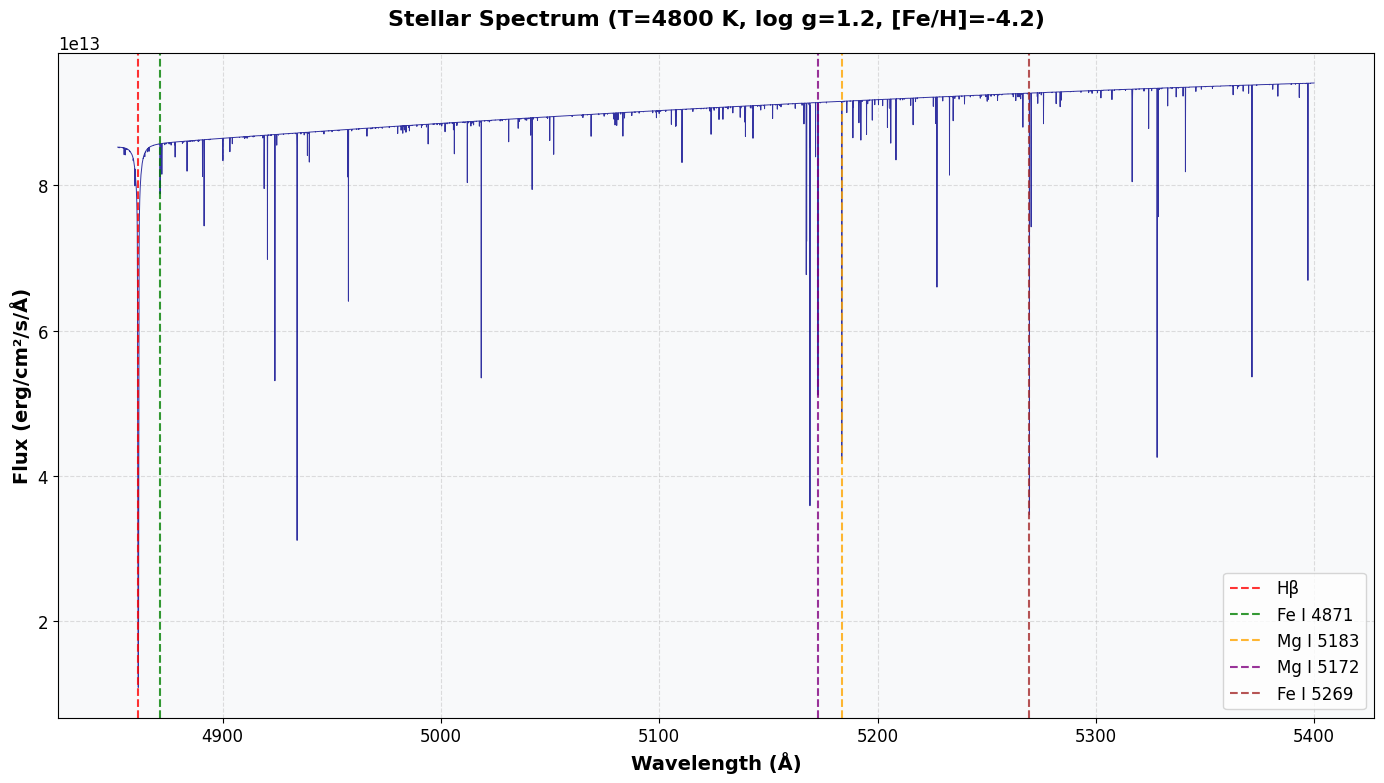

In [8]:
plot_spectrum(wavelength, flux, headers, lines = True)

## 5. Cont norm testing

#### Generate common noise example

In [ ]:
common_noise = cont_norm.generate_noise(flux.shape, noise=0.01)
plt.plot(wavelength, common_noise)

Asym sigma clipping, using median of the sigma-clipped values as the continuum estimate

In [ ]:
flux1 = cont_norm.a_sigclip(flux)
plot_spectrum(wavelength, flux1, headers)

Local asymmetric k-sigma clipping continuum normalization in moving wavelength windows, 10 A window

In [ ]:
%%time
flux_local_asigclip = cont_norm.local_asymmetric_sigclip(flux, wavelength, sigma_lower=1.2, sigma_upper=4.0, window_width=20.0)
plot_spectrum(wavelength, flux_local_asigclip, headers)

### Local asymmetric sigma clipping, in sliding window

In [ ]:
test_spectra = [
    (0, "Dense spectrum"),
    (19393 - 1, "High metallicity spectrum"),
    (19393 // 2, "Mid-range spectrum")
]

In [ ]:
# Define method to test
METHOD_TO_TEST = 'local_asymmetric_sigclip'
out_csv = METHOD_TO_TEST + '_results.csv'
arrays_file = METHOD_TO_TEST + '_arrays.npz'

rows = []
arrays_data = {}

did 
- 0: 0.2, 0.1, 0.01, 0.005, 0.05
- 19393 - 1: 0.05, 0.005, 0.01, 0.1, 0.2
- 19393 // 2: 0.2, 0.1, 0.05, 0.1, 0.005

In [ ]:
spec_idx = 19393 // 2
wavelength_test, flux_test = reader.get_wavelength_flux(spec_idx)
info_test = reader.get_spectrum_info(spec_idx)
params_test = info_test.get('stellar_parameters', {})
headers_test = {k: params_test.get(k, 'N/A') for k in ['teff', 'log_g', 'metallicity']}
info_test = reader.get_spectrum_info(spec_idx)
noise_level = 0.005
test_noise = global_noise_realizations[0.01] #noise_levels = [0.005, 0.01, 0.05, 0.1, 0.15, 0.2]

In [ ]:
%%time
flux_clean_norm = cont_norm.local_asymmetric_sigclip(flux_test, wavelength_test, sigma_lower=1.2, sigma_upper=4.0, window_width=55.0)
plot_spectrum(wavelength_test, flux_clean_norm, headers_test)

In [ ]:
plot_sections(method_B, wavelength_test)

In [ ]:
%%time
# Add noise then normalize (method B)
flux_with_noise = flux_test + test_noise
method_B = cont_norm.local_asymmetric_sigclip(flux_with_noise, wavelength_test, sigma_lower=1.2, sigma_upper=4.0, window_width=55.0)

In [ ]:
# correlation with -noise (continuum robustness test)
correlation_test_diff = method_B - (flux_clean_norm + test_noise)
# guard against degenerate case (constant arrays)
try:
    correlation_with_neg_noise = np.corrcoef(correlation_test_diff, -test_noise)[0,1]
except Exception:
    correlation_with_neg_noise = np.nan

noise_std = test_noise.std() if test_noise.std() > 0 else np.nan

# compute SNR on normalized flux scale (median ~ 1)
snr = (np.median(flux_clean_norm) / noise_std) if (noise_std and not np.isnan(noise_std)) else np.nan

elapsed = (6*60 + 25) + (2*60 + 22)

# Create unique key for this result
result_key = f"{spec_idx}_{noise_level}"
            
# Store arrays separately
arrays_data[result_key] = {
                'wavelength': wavelength_test,
                'method_A': flux_clean_norm,
                'method_B': method_B,
                'flux_diff': method_B - flux_clean_norm,
                'test_noise': test_noise  # Store the noise used for reproducibility
            }

row = {
                'spectrum_index': int(spec_idx),
                'spectrum_description': 'Mid-range spectrum', #  "High metallicity spectrum", "Mid-range spectrum"
                'noise_level': float(noise_level),
                'snr': float(snr),
                'noise_std': float(noise_std),
                'correlation_with_neg_noise': float(correlation_with_neg_noise),
                'success': True,
                'elapsed_time_s': float(elapsed),
                'result_key': result_key  # Reference to arrays
            }
rows.append(row)

In [ ]:
rows[-1]

In [ ]:
# Build DataFrame and save
df = pd.DataFrame(rows)
# set MultiIndex so results can be looked up by (spectrum_index, noise_level)
df_indexed = df.set_index(['spectrum_index', 'noise_level']).sort_index()

# Save CSV with metadata only (no large arrays)
df.to_csv(out_csv, index=False)
print(f"\nResults metadata saved to: {out_csv}")

# Save arrays separately using numpy
np.savez_compressed(arrays_file, **arrays_data)
print(f"Full arrays saved to: {arrays_file}")
print(f"Array data keys: {list(arrays_data.keys())}")

Median filtering, window = len(flux)//100

In [ ]:
flux3 = cont_norm.contnorm_2stage(flux, len(flux)//100)
plot_spectrum(wavelength, flux3, headers)

Median filtering, window = len(flux)//2

In [ ]:
test_file = "../data/test.txt"
data = np.loadtxt(
    test_file,
    delimiter=",",
    converters={
        0: lambda s: float(s.decode('utf-8').strip("()")),
        1: lambda s: float(s.decode('utf-8').strip("()"))
    }
)
col1 = data[:, 0]
col2 = data[:, 1]

plot_spectrum(wavelength, col1, headers) # width = len(flux)//2, median filter

2 stage: median filter and then asym sigma clipping

In [ ]:
flux4 = cont_norm.contnorm_2stage(flux, len(flux)//3)
plot_spectrum(wavelength, flux4, headers)

### Polynomial fitting with least squares and huber loss

In [9]:
%%time
flux_ls, _ = cont_norm.robust_polyfit_huber(flux, wavelength, degree = 2, enable_clipping=True)

CPU times: user 1.17 s, sys: 20.8 ms, total: 1.19 s
Wall time: 1.23 s


This is the upper bound on a single run of robust_polyfit_huber, e.g. spectrum below is as dense as it gets.

So, e.g. a batch of size ~50 --> ~ 30s on CPU (upper bound)

I can port this method to PyTorch tensors and tensor operations on GPU ~ 1-3s?

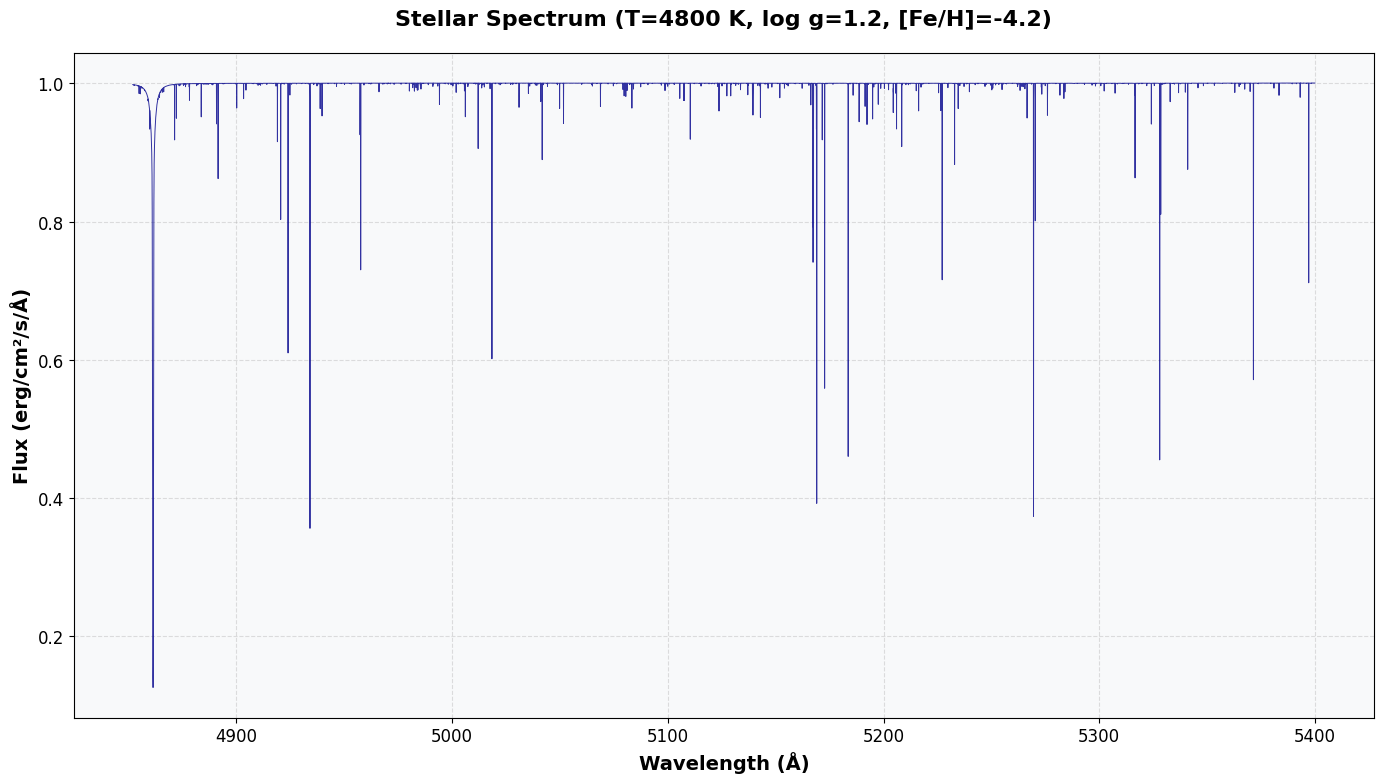

In [10]:
plot_spectrum(wavelength, flux_ls, headers)

#### Plot Specific Wavelength Ranges

Focus on specific wavelength regions to examine spectral features in detail.

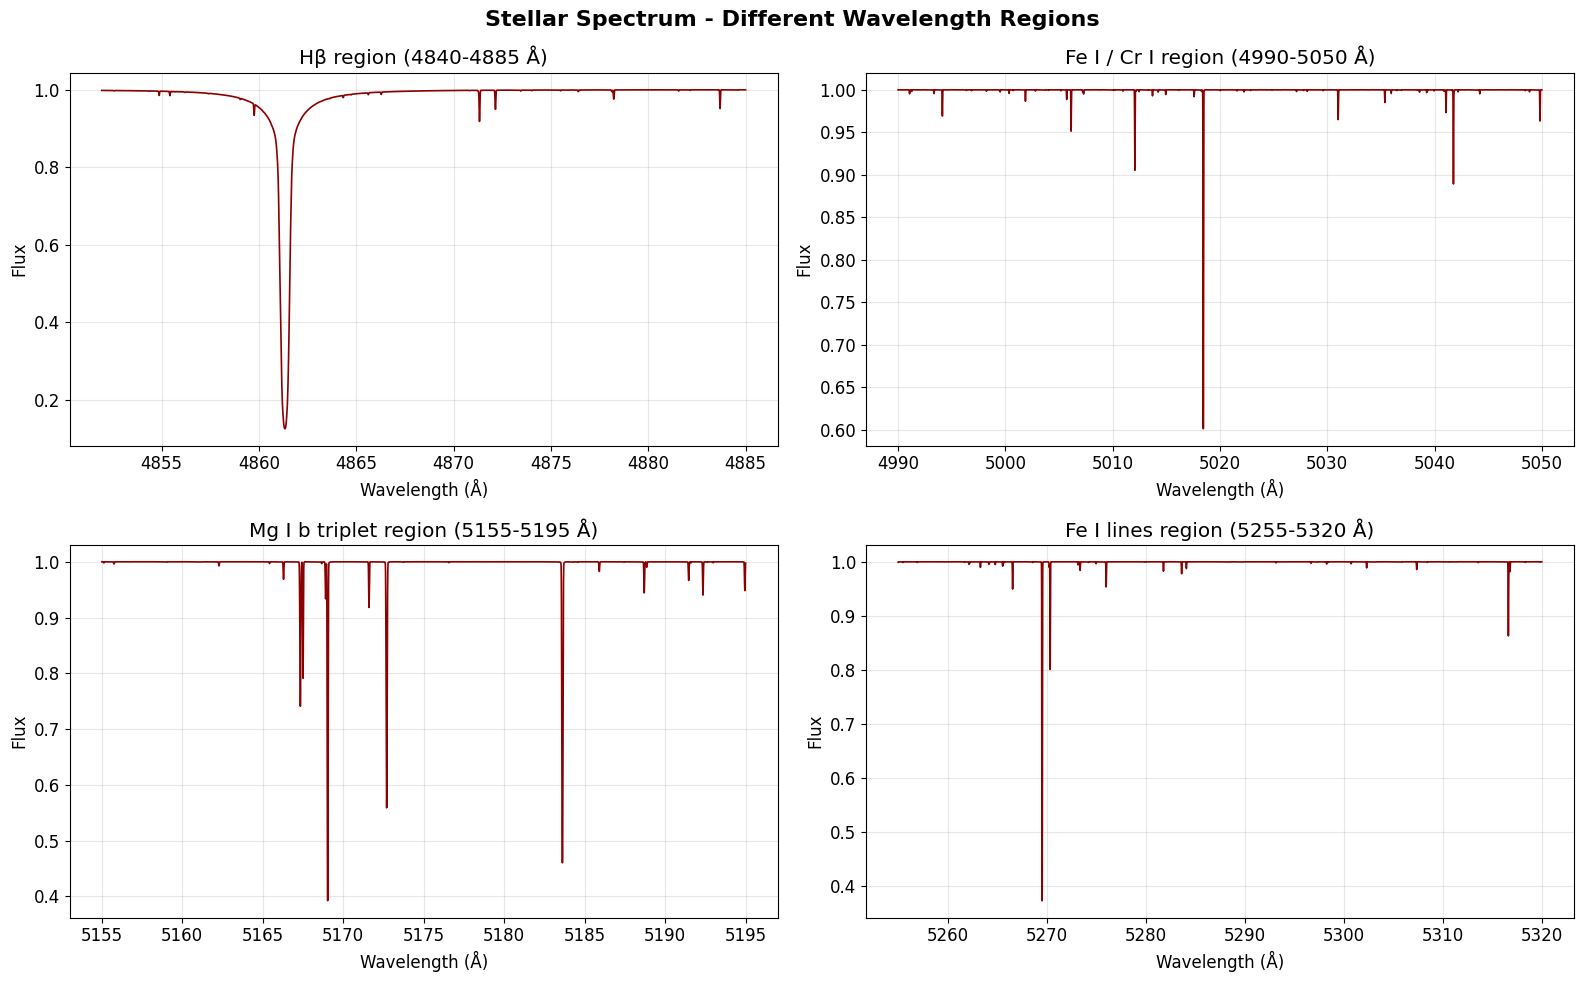

In [11]:
plot_sections(flux_ls, wavelength)

In [ ]:
plot_sections(flux_ls + common_noise, wavelength, text = ' cont norm first')

In [ ]:
flux_ls_noisy, _ = cont_norm.robust_polyfit_huber(flux + common_noise, wavelength, degree = 2, enable_clipping=True)
plot_sections(flux_ls_noisy, wavelength, text = ' add noise first')

In [ ]:
plot_sections(flux_ls_noisy - (flux_ls + common_noise), wavelength, text = ' flux difference (before-after)')
plot_sections(common_noise, wavelength, text = ' common noise')

In [ ]:
plot_sections(flux_ls_noisy/(flux_ls +common_noise), wavelength, text = ' flux ratio (before/after)')

## Testing Robust Polynomial Fitting with Noise

Compare the improved `robust_polyfit_huber` with iterative sigma clipping enabled vs disabled.

In [ ]:
# Plot comparison of all methods
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Robust Polynomial Fitting: Handling Noise Before vs After Normalization', fontsize=14)

# Define wavelength ranges for detailed comparison
ranges = [
    (4840, 4885, "Hβ region"),
    (4990, 5050, "Fe I / Cr I region"), 
    (5155, 5195, "Mg I b triplet region"),
    (5255, 5320, "Fe I lines region")
]

for i, (wmin, wmax, label) in enumerate(ranges):
    ax = axes[i//2, i%2]
    mask = (wavelength >= wmin) & (wavelength <= wmax)
    
    if np.any(mask):
        wl_zoom = wavelength[mask]
        
        # Plot all three methods
        ax.plot(wl_zoom, flux_method1[mask], 'b-', alpha=0.7, linewidth=1.0, 
                label='Method 1: Norm→Noise')
        ax.plot(wl_zoom, flux_method2a[mask], 'r-', alpha=0.7, linewidth=1.0,
                label='Method 2a: Noise→Norm (no clip)')
        ax.plot(wl_zoom, flux_method2b[mask], 'g-', alpha=0.7, linewidth=1.0,
                label='Method 2b: Noise→Norm (clip)')
        
        # Add continuum = 1 reference line
        ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
        
        ax.set_xlabel('Wavelength (Å)')
        ax.set_ylabel('Normalized Flux')
        ax.set_title(f'{label} ({wmin}-{wmax} Å)')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        
        # Set y-axis to show continuum level clearly
        ax.set_ylim(0.85, 1.15)
    else:
        ax.text(0.5, 0.5, 'No data in range', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{label} ({wmin}-{wmax} Å)')

plt.tight_layout()
plt.show()

# Quantitative comparison
print("\n=== Quantitative Comparison ===")
diff_2a_vs_1 = flux_method2a - flux_method1
diff_2b_vs_1 = flux_method2b - flux_method1

print(f"RMS difference (Method 2a vs 1): {np.sqrt(np.mean(diff_2a_vs_1**2)):.6f}")
print(f"RMS difference (Method 2b vs 1): {np.sqrt(np.mean(diff_2b_vs_1**2)):.6f}")
print(f"Max difference (Method 2a vs 1): {np.max(np.abs(diff_2a_vs_1)):.6f}")
print(f"Max difference (Method 2b vs 1): {np.max(np.abs(diff_2b_vs_1)):.6f}")

print(f"\nImprovement with clipping:")
print(f"RMS reduction: {(1 - np.sqrt(np.mean(diff_2b_vs_1**2))/np.sqrt(np.mean(diff_2a_vs_1**2)))*100:.1f}%")
print(f"Max error reduction: {(1 - np.max(np.abs(diff_2b_vs_1))/np.max(np.abs(diff_2a_vs_1)))*100:.1f}%")

## Noise testing

Let's break down what we're actually testing:

**Method A**: `normalize(flux) + noise` → `flux_ls + common_noise`
**Method B**: `normalize(flux + noise)` → `flux_ls_noisy`

**The difference**: `flux_ls_noisy - (flux_ls + common_noise)`

**What should this difference be?**

If normalization is **perfectly robust** to noise:
- `flux_ls_noisy ≈ flux_ls` (the noise doesn't affect the normalization)
- So: `flux_ls_noisy - (flux_ls + common_noise) ≈ -common_noise`

**If normalization is NOT robust** to noise:
- The noise biases the continuum fit, so `flux_ls_noisy ≠ flux_ls`
- The difference will be some combination of bias + noise effects

In [10]:
# Extended noise range (same as before)
noise_levels = [0.005, 0.01, 0.05, 0.1, 0.15, 0.2]

# PRE-GENERATE ALL NOISE REALIZATIONS GLOBALLY
# This ensures exactly the same noise is applied across all spectra and methods
print("Pre-generating noise realizations for consistency across all tests...")

# Get a representative spectrum to determine the flux shape
wavelength_ref, flux_ref = reader.get_wavelength_flux(0)
flux_shape = flux_ref.shape

# Generate all noise realizations once with different seeds for each noise level
global_noise_realizations = {}
for noise_level in noise_levels:
    # Use a different seed for each noise level to get independent realizations
    # but the same seed ensures reproducibility across runs
    seed = int(noise_level * 10000)  # Convert to integer seed
    noise_array = cont_norm.generate_noise(flux_shape, noise=noise_level, seed=seed)
    global_noise_realizations[noise_level] = noise_array
    print(f"  Generated noise level {noise_level:.3f} (seed={seed}, std={noise_array.std():.6f})")

print(f"All noise realizations generated with shape {flux_shape}")
print()

Pre-generating noise realizations for consistency across all tests...
  Generated noise level 0.005 (seed=50, std=0.005019)
  Generated noise level 0.010 (seed=100, std=0.009989)
  Generated noise level 0.050 (seed=500, std=0.050134)
  Generated noise level 0.100 (seed=1000, std=0.100023)
  Generated noise level 0.150 (seed=1500, std=0.150531)
  Generated noise level 0.200 (seed=2000, std=0.200737)
All noise realizations generated with shape (107467,)



In [11]:
# Flexible testing framework for different continuum normalization methods
# =======================================================================

# 1. CHOOSE YOUR METHOD TO TEST
# Change this variable to test different methods:
METHOD_TO_TEST = "local_asymmetric_sigclip"  # Options: "local_asymmetric_sigclip", "robust_polyfit_huber", "legendre_polyfit_huber"

# 2. DEFINE METHOD CONFIGURATIONS
method_configs = {
    "local_asymmetric_sigclip": {
        "function": cont_norm.local_asymmetric_sigclip,
        "params": {
            "sigma_lower": 1.2, 
            "sigma_upper": 4.0, 
            "window_width": 55.0
        },
        "returns_continuum": False,  # This method only returns normalized flux
        "description": "Local Asymmetric Sigma Clipping (moving window)"
    },
    "robust_polyfit_huber": {
        "function": cont_norm.robust_polyfit_huber,
        "params": {
            "degree": 2, 
            "enable_clipping": True, 
            "sigma_lower": 2.5, 
            "sigma_upper": 2.5,
            "max_iter": 3
        },
        "returns_continuum": True,
        "description": "Robust Polynomial + Huber Loss"
    },
    "legendre_polyfit_huber": {
        "function": cont_norm.legendre_polyfit_huber,
        "params": {
            "degree": 2, 
            "enable_clipping": True, 
            "sigma_lower": 2.5, 
            "sigma_upper": 2.5,
            "max_iter": 3
        },
        "returns_continuum": True,
        "description": "Legendre Polynomial + Huber Loss"
    }
}

# 3. NORMALIZATION FUNCTION WRAPPER
def normalize_spectrum(flux, wavelength, method_name):
    """Wrapper function to handle different normalization methods consistently."""
    config = method_configs[method_name]
    func = config["function"]
    params = config["params"]
    
    if config["returns_continuum"]:
        # Method returns (normalized_flux, continuum)
        norm_flux, continuum = func(flux, wavelength, **params)
        return norm_flux
    else:
        # Method only returns normalized_flux
        norm_flux = func(flux, wavelength, **params)
        return norm_flux

print(f"🎯 SELECTED METHOD: {METHOD_TO_TEST}")
print(f"📝 Description: {method_configs[METHOD_TO_TEST]['description']}")
print(f"⚙️  Parameters: {method_configs[METHOD_TO_TEST]['params']}")
print("\n💡 To test a different method, change the METHOD_TO_TEST variable above!")

🎯 SELECTED METHOD: local_asymmetric_sigclip
📝 Description: Local Asymmetric Sigma Clipping (moving window)
⚙️  Parameters: {'sigma_lower': 1.2, 'sigma_upper': 4.0, 'window_width': 55.0}

💡 To test a different method, change the METHOD_TO_TEST variable above!


In [ ]:
print(f"=== COMPREHENSIVE NOISE ROBUSTNESS TEST ===")
print(f"Testing method: {METHOD_TO_TEST}")
print(f"Testing multiple spectra and extended noise range...\n")

# Define test spectra (keep the same indices you used before)
test_spectra = [
    (0, "Dense spectrum"),
    (19393 - 1, "High metallicity spectrum"),
    (19393 // 2, "Mid-range spectrum")
]

rows = []  # will collect dicts for DataFrame
arrays_data = {}  # will store full arrays separately

for spec_idx, spec_description in test_spectra:
    print(f"\n{'='*60}")
    print(f"TESTING: {spec_description} (index {spec_idx})")
    print(f"{'='*60}")
    
    wavelength_test, flux_test = reader.get_wavelength_flux(spec_idx)
    info_test = reader.get_spectrum_info(spec_idx)
    params_test = info_test.get('stellar_parameters', {})
    headers_test = {k: params_test.get(k, 'N/A') for k in ['teff', 'log_g', 'metallicity']}
    print(f"Spectrum params: T={headers_test['teff']}K, log g={headers_test['log_g']}, [Fe/H]={headers_test['metallicity']}")
    
    # Verify flux shape matches the reference
    if flux_test.shape != flux_shape:
        print(f"WARNING: Flux shape mismatch! Expected {flux_shape}, got {flux_test.shape}")
        print("Skipping this spectrum...")
        continue
    
    for noise_level in noise_levels:
        t0 = time.time()
        
        # Use the pre-generated noise realization
        test_noise = global_noise_realizations[noise_level]
        
        elapsed = None
        try:
            # Clean normalization then add noise (method A)
            flux_clean_norm = normalize_spectrum(flux_test, wavelength_test, METHOD_TO_TEST)
            method_A = flux_clean_norm + test_noise

            # Add noise then normalize (method B)
            flux_with_noise = flux_test + test_noise
            method_B = normalize_spectrum(flux_with_noise, wavelength_test, METHOD_TO_TEST)

            # correlation with -noise (continuum robustness test)
            correlation_test_diff = method_B - (flux_clean_norm + test_noise)
            # guard against degenerate case (constant arrays)
            try:
                correlation_with_neg_noise = np.corrcoef(correlation_test_diff, -test_noise)[0,1]
            except Exception:
                correlation_with_neg_noise = np.nan

            noise_std = test_noise.std() if test_noise.std() > 0 else np.nan

            # compute SNR on normalized flux scale (median ~ 1)
            snr = (np.median(flux_clean_norm) / noise_std) if (noise_std and not np.isnan(noise_std)) else np.nan

            elapsed = time.time() - t0

            # Create unique key for this result
            result_key = f"{spec_idx}_{noise_level}"
            
            # Store arrays separately
            arrays_data[result_key] = {
                'wavelength': wavelength_test,
                'method_A': method_A,
                'method_B': method_B,
                'flux_diff': method_B - method_A,
                'test_noise': test_noise  # Store the noise used for reproducibility
            }

            row = {
                'spectrum_index': int(spec_idx),
                'spectrum_description': spec_description,
                'noise_level': float(noise_level),
                'snr': float(snr),
                'noise_std': float(noise_std),
                'correlation_with_neg_noise': float(correlation_with_neg_noise),
                'success': True,
                'elapsed_time_s': float(elapsed),
                'result_key': result_key  # Reference to arrays
            }
            rows.append(row)

            continuum_robust = (not np.isnan(correlation_with_neg_noise)) and (correlation_with_neg_noise > 0.7)
            print(f"Noise {noise_level:.3f} (SNR {snr:.1f}): corr={correlation_with_neg_noise:.3f} {'✓ robust' if continuum_robust else '✗ biased'} [{elapsed:.2f}s]")

        except Exception as e:
            elapsed = time.time() - t0
            print(f"Noise {noise_level:.3f}: ❌ FAILED - {str(e)} [{elapsed:.2f}s]")
            rows.append({
                'spectrum_index': int(spec_idx),
                'spectrum_description': spec_description,
                'noise_level': float(noise_level),
                'snr': np.nan,
                'noise_std': np.nan,
                'correlation_with_neg_noise': np.nan,
                'success': False,
                'elapsed_time_s': float(elapsed),
                'result_key': None
            })

# Build DataFrame and save
df = pd.DataFrame(rows)
# set MultiIndex so results can be looked up by (spectrum_index, noise_level)
df_indexed = df.set_index(['spectrum_index', 'noise_level']).sort_index()

# Save CSV with metadata only (no large arrays)
out_csv = METHOD_TO_TEST + "_results.csv"
df.to_csv(out_csv, index=False)
print(f"\nResults metadata saved to: {out_csv}")

# Save arrays separately using numpy
arrays_file = METHOD_TO_TEST + "_arrays.npz"
np.savez_compressed(arrays_file, **arrays_data)
print(f"Full arrays saved to: {arrays_file}")
print(f"Array data keys: {list(arrays_data.keys())}")

print(f"\n🎯 CONSISTENCY CHECK:")
print(f"✓ Same noise applied to all spectra for each noise level")
print(f"✓ All spectra tested with identical noise realizations")

Correlation with -noise shows if the method recovers clean-like spectra

In [ ]:
# Load the results from CSV
results_file = METHOD_TO_TEST + "_results.csv"
df = pd.read_csv(results_file)

plt.figure(figsize=(10, 5))
plt.title(f'Noise Robustness Analysis: {METHOD_TO_TEST}', fontsize=16, fontweight='bold')

# Group by spectrum_index and plot correlations for each spectrum
for spectrum_index, group in df.groupby('spectrum_index'):
    # Sort by noise level and get successful results
    group = group.sort_values('noise_level')
    successful = group[group['success']]
    
    if not successful.empty:
        plt.plot(successful['noise_level'], 
                successful['correlation_with_neg_noise'], 
                'o-', linewidth=2, markersize=6,
                label=f"Spectrum {spectrum_index} ({successful.iloc[0]['spectrum_description']})")

# Add reference lines and labels
plt.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='Excellent threshold')
plt.axhline(y=0.6, color='orange', linestyle='--', alpha=0.7, label='Good threshold')
plt.xlabel('Noise Level')
plt.ylabel('Correlation with -Noise')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
# Provide a convenient accessor where you can do data[spectrum_index, noise_level]
class ResultsAccessor:
    def __init__(self, df_indexed, arrays_file):
        self._df = df_indexed
        self._arrays = np.load(arrays_file, allow_pickle=True)
        print(f"Loaded arrays file with keys: {list(self._arrays.keys())}")
        
    def __getitem__(self, key):
        # Expect key to be (spectrum_index, noise_level)
        if not isinstance(key, tuple) or len(key) != 2:
            raise KeyError("Use data[spectrum_index, noise_level] with a tuple key")
        try:
            row = self._df.loc[key].copy()
            
            # Get the result key for array lookup
            result_key = row['result_key']
            if result_key is None or pd.isna(result_key):
                raise ValueError(f"No array data available for spectrum_index={key[0]}, noise_level={key[1]}")
            
            # Load arrays from npz file - the data is stored as a dictionary
            if result_key in self._arrays:
                stored_data = self._arrays[result_key].item()
                if isinstance(stored_data, dict):
                    # Extract each array from the stored dictionary
                    for array_name in ['wavelength', 'method_A', 'method_B', 'flux_diff']:
                        if array_name in stored_data:
                            row[array_name] = stored_data[array_name]
                        else:
                            print(f"Warning: {array_name} not found in stored data for key {result_key}")
                            row[array_name] = None
                else:
                    print(f"Warning: Stored data for {result_key} is not a dictionary")
                    row['wavelength'] = None
                    row['method_A'] = None
                    row['method_B'] = None
                    row['flux_diff'] = None
            else:
                print(f"Warning: {result_key} not found in arrays file")
                row['wavelength'] = None
                row['method_A'] = None
                row['method_B'] = None
                row['flux_diff'] = None
            
            return row
        except KeyError:
            raise KeyError(f"No data found for spectrum_index={key[0]}, noise_level={key[1]}")
    
    def close(self):
        """Close the arrays file"""
        self._arrays.close()

In [ ]:
def plot_detailed_analysis(spectrum_index, noise_level, method_name):
    """
    Plot detailed analysis of the flux differences and normalized spectra for a given spectrum and noise level.
    
    Args:
        spectrum_index (int): Index of the spectrum to analyze
        noise_level (float): Noise level to analyze
        method_name (str): Method name to determine file names
    """
    try:
        # File paths
        csv_file = f"{method_name}_results.csv"
        arrays_file = f"{method_name}_arrays.npz"
        
        print(f"Loading metadata from {csv_file}...")
        print(f"Loading arrays from {arrays_file}...")
        
        # Read CSV file
        df = pd.read_csv(csv_file)
        df_indexed = df.set_index(['spectrum_index', 'noise_level']).sort_index()
        
        # Check if the requested indices exist
        if spectrum_index not in df_indexed.index.get_level_values(0):
            print(f"Error: Spectrum index {spectrum_index} not found in results.")
            print(f"Available spectrum indices: {df_indexed.index.get_level_values(0).unique()}")
            return
            
        if noise_level not in df_indexed.xs(spectrum_index).index:
            print(f"Error: Noise level {noise_level} not found for spectrum {spectrum_index}.")
            print(f"Available noise levels: {df_indexed.xs(spectrum_index).index.values}")
            return
        
        # Get metadata row
        row = df_indexed.loc[(spectrum_index, noise_level)]
        result_key = row['result_key']
        
        print(f"Loading arrays for result key: {result_key}")
        
        # Load arrays directly from npz file
        arrays = np.load(arrays_file, allow_pickle=True)
        
        if result_key not in arrays:
            print(f"Error: Result key '{result_key}' not found in arrays file")
            print(f"Available keys: {list(arrays.keys())}")
            arrays.close()
            return
        
        # Extract the array data
        array_data = arrays[result_key].item()
        
        if not isinstance(array_data, dict):
            print(f"Error: Array data is not a dictionary. Type: {type(array_data)}")
            arrays.close()
            return
        
        # Get the individual arrays
        wavelength = array_data.get('wavelength')
        method_A = array_data.get('method_A')
        method_B = array_data.get('method_B')
        flux_diff = array_data.get('flux_diff')
        
        # Verify all arrays are present and valid
        if any(arr is None for arr in [wavelength, method_A, method_B, flux_diff]):
            print("Error: Some arrays are missing from the data")
            for name, arr in zip(['wavelength', 'method_A', 'method_B', 'flux_diff'], 
                                [wavelength, method_A, method_B, flux_diff]):
                if arr is None:
                    print(f"  {name}: None")
                else:
                    print(f"  {name}: shape {arr.shape}")
            arrays.close()
            return
        
        # Verify arrays
        print(f"wavelength shape: {wavelength.shape}")
        print(f"method_A shape: {method_A.shape}")
        print(f"method_B shape: {method_B.shape}")
        print(f"flux_diff shape: {flux_diff.shape}")
        
        print("\nGenerating plots...")
        
        # Plot 1: Flux difference
        plot_sections(flux_diff, wavelength, text=' flux difference (before-after)')
        
        # Plot 2: Normalized spectrum + noise
        plot_sections(method_A, wavelength, text=' normalised + noise')
        
        # Plot 3: Noisy normalized spectrum
        plot_sections(method_B, wavelength, text=' + noise then normalise')

        # Plot 4: Entire spectrum

        info_test = reader.get_spectrum_info(spectrum_index)
        params_test = info_test.get('stellar_parameters', {})
        headers_test = {k: params_test.get(k, 'N/A') for k in ['teff', 'log_g', 'metallicity']}
        plot_spectrum(wavelength, method_B, headers_test, text = ' (add noise then normalise)')
        
        # Print some statistics
        print(f"\nAnalysis for spectrum {spectrum_index} with noise level {noise_level}:")
        print(f"Success: True")
        print(f"SNR: {row.snr:.1f}")
        print(f"Noise std: {row.noise_std:.6f}")
        print(f"Correlation with -noise: {row.correlation_with_neg_noise:.3f}")
        print(f"Elapsed time: {row.elapsed_time_s:.2f}s")
        
        # Clean up
        arrays.close()
        
    except Exception as e:
        print(f"Error analyzing spectrum {spectrum_index} with noise level {noise_level}:")
        print(f"Error details: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

did 
- 0
- 19393 - 1
- 19393 // 2
  
noise_levels = [0.005, 0.01, 0.05, 0.1, 0.15, 0.2]

Loading metadata from legendre_polyfit_huber_results.csv...
Loading arrays from legendre_polyfit_huber_arrays.npz...
Loading arrays for result key: 0_0.1
wavelength shape: (107467,)
method_A shape: (107467,)
method_B shape: (107467,)
flux_diff shape: (107467,)

Generating plots...


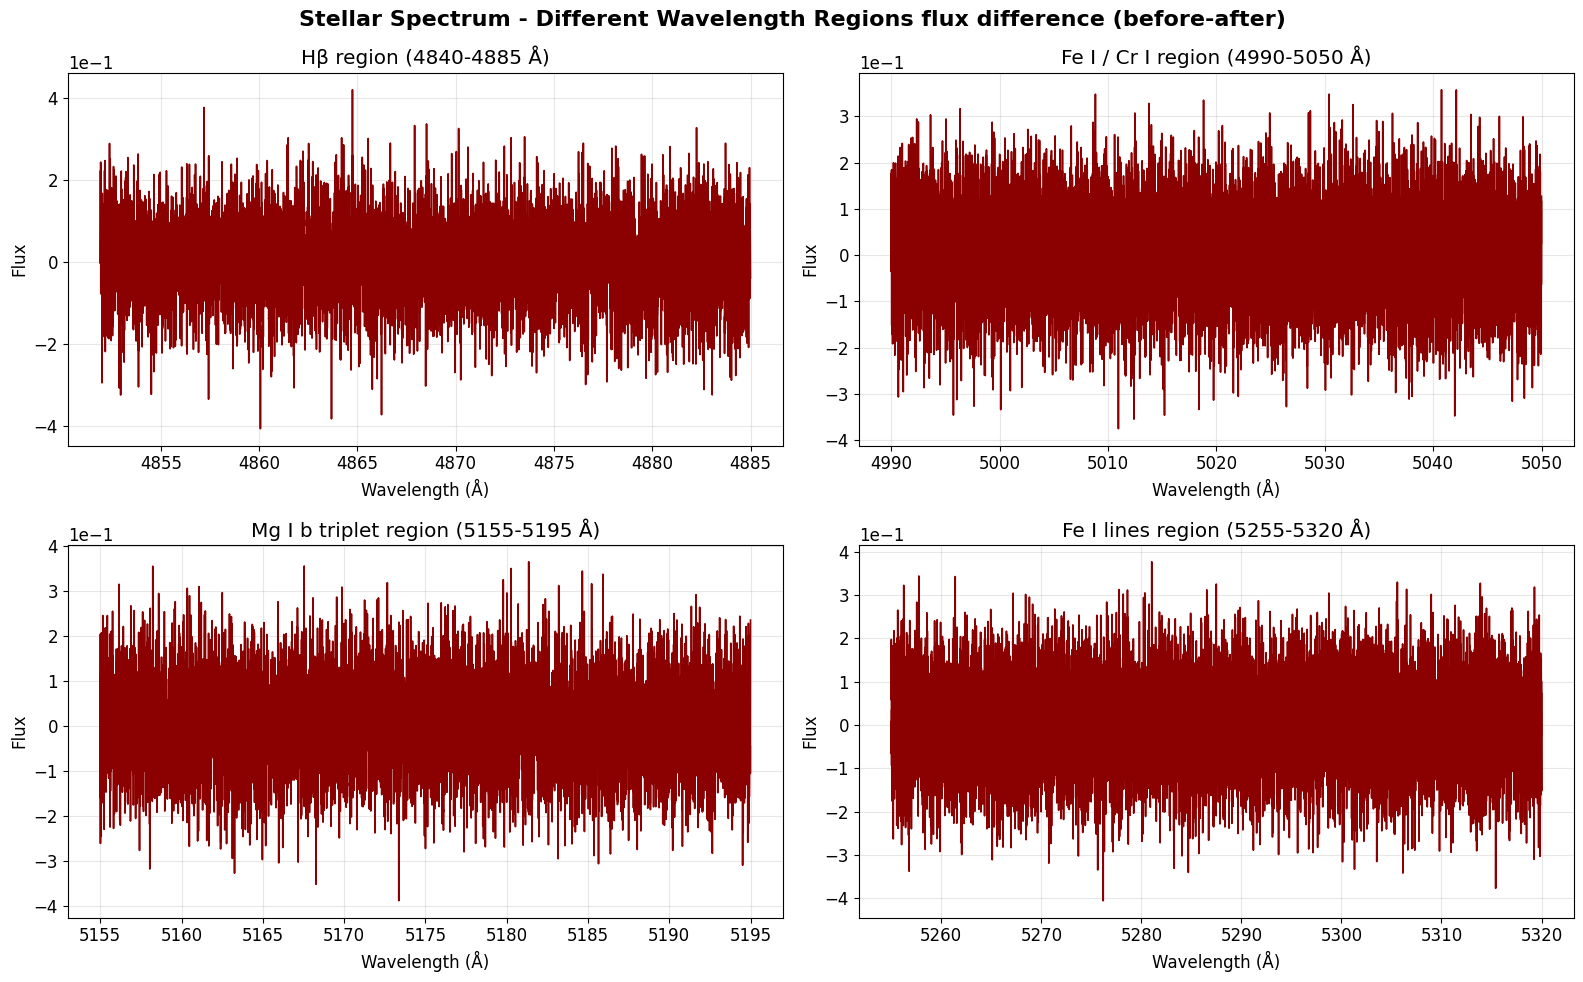

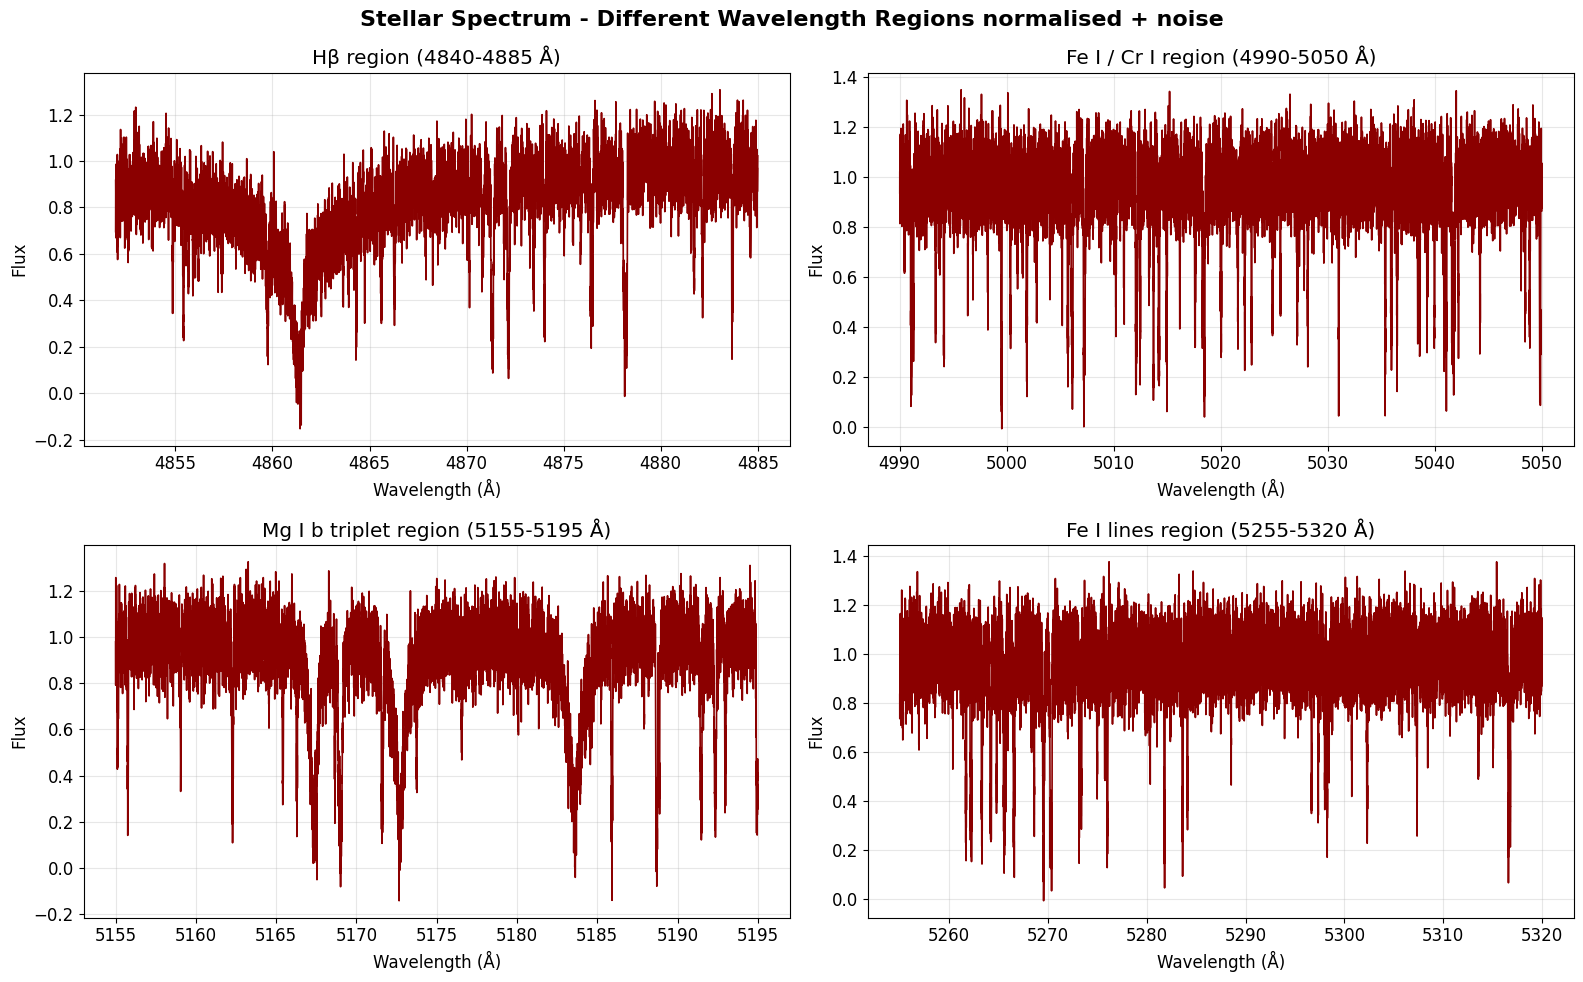

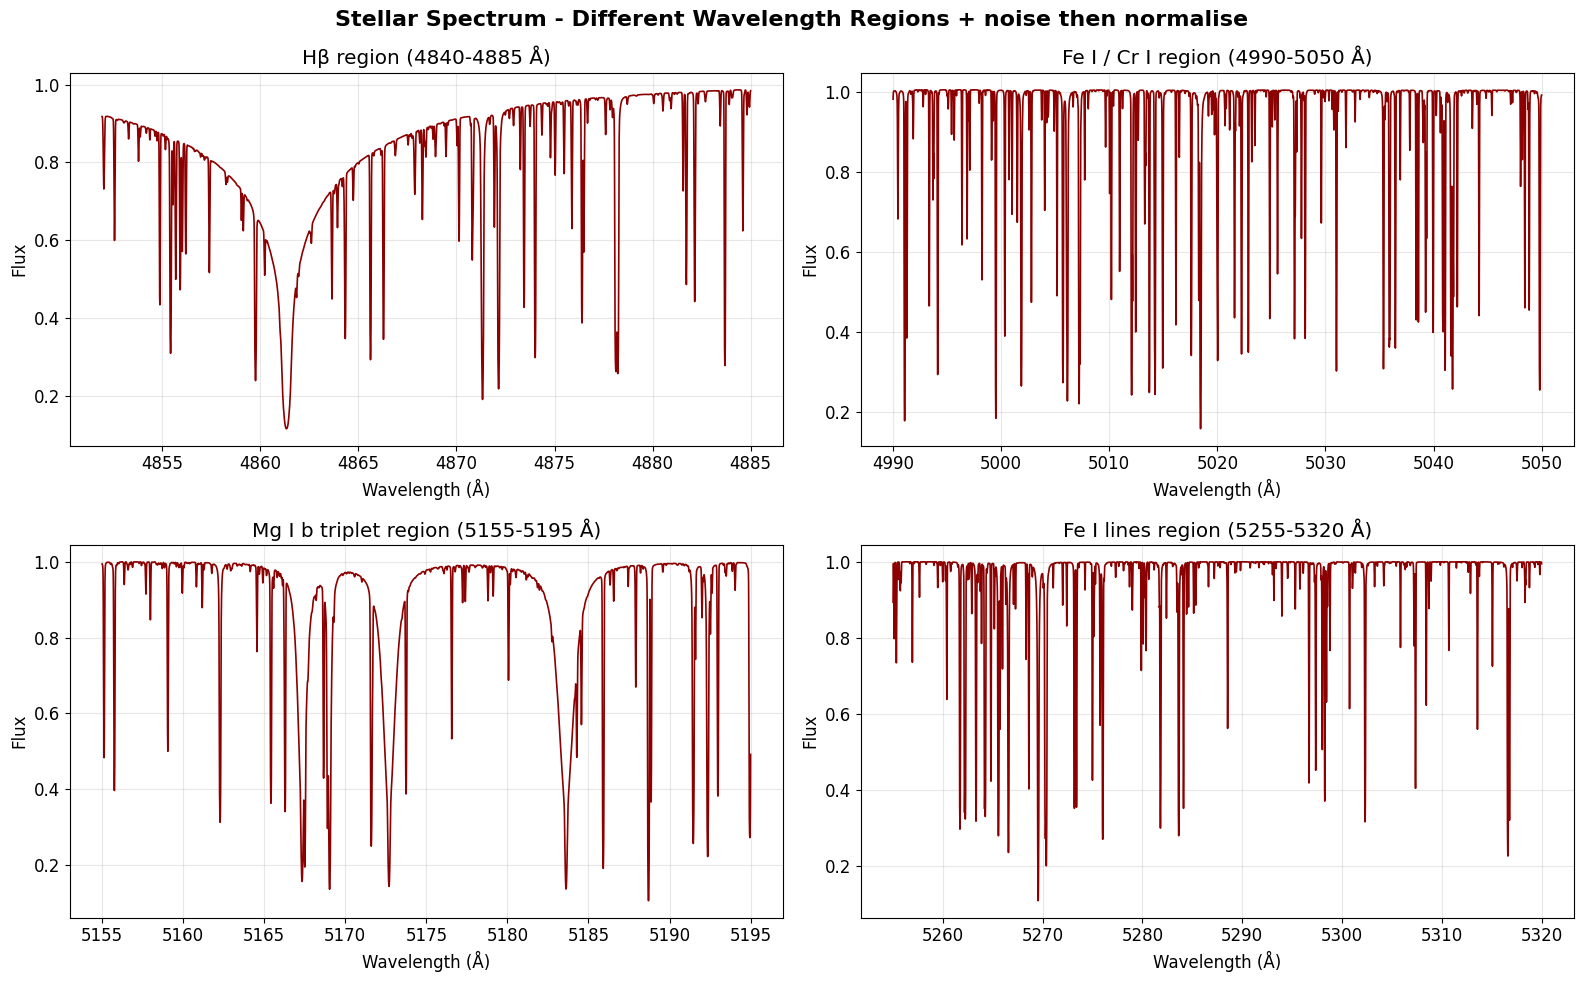

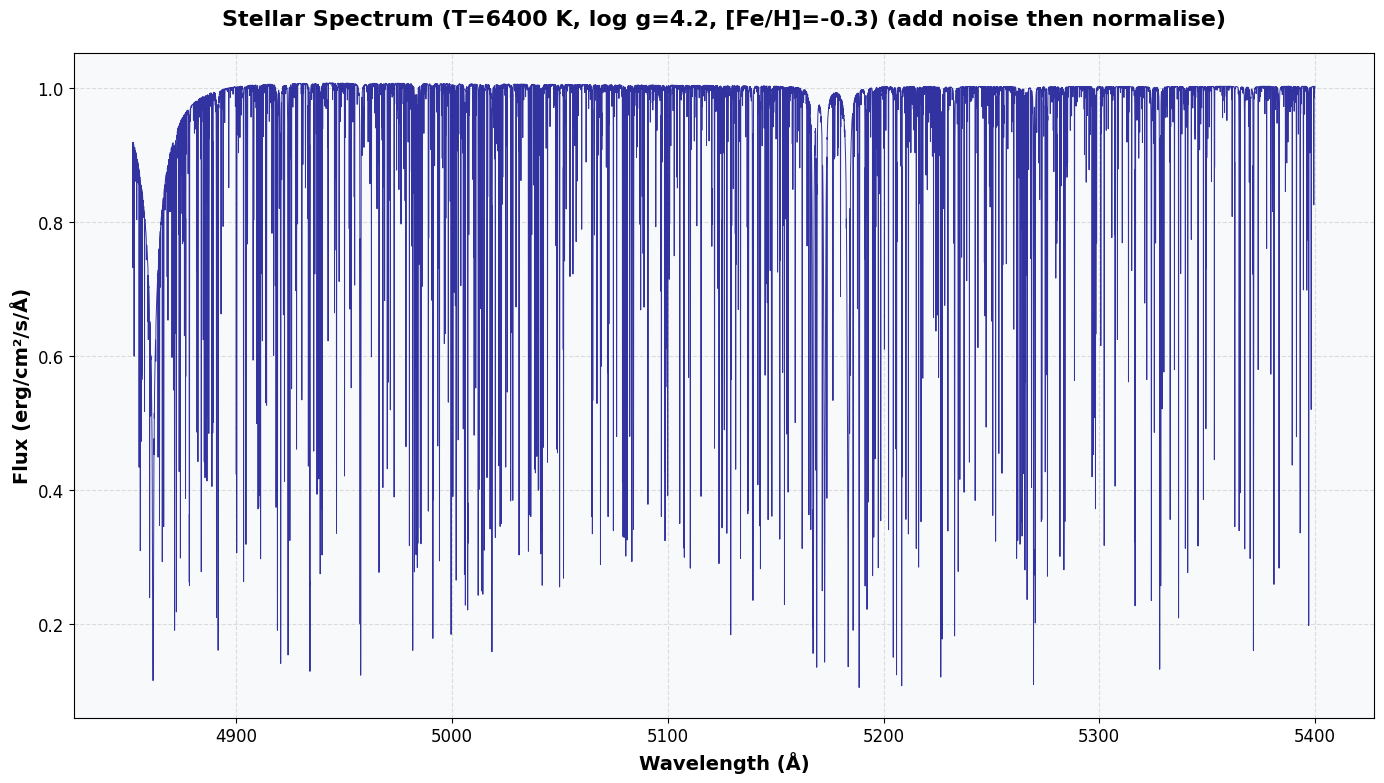


Analysis for spectrum 0 with noise level 0.1:
Success: True
SNR: 10.0
Noise std: 0.100187
Correlation with -noise: 1.000
Elapsed time: 0.89s


In [19]:
plot_detailed_analysis(0, 0.1, "legendre_polyfit_huber")

In [26]:
def plot_sections_with_trend(flux, wavelength, text='', n_bins=100, trend_color='red', trend_alpha=0.8):
    """
    Plot specific wavelength ranges with overlaid binned median trend lines.
    
    Parameters:
    -----------
    flux : array-like
        Flux values to plot
    wavelength : array-like
        Wavelength values
    text : str, optional
        Additional text for the plot title
    n_bins : int, optional
        Number of bins for trend calculation (default: 100)
    trend_color : str, optional
        Color for the trend line (default: 'red')
    trend_alpha : float, optional
        Alpha transparency for trend line (default: 0.8)
    """
    # Plot specific wavelength ranges to examine spectral features
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Stellar Spectrum - Different Wavelength Regions' + text, fontsize=16, fontweight='bold')
    
    # Define wavelength ranges of interest
    ranges = [
        (4840, 4885, "Hβ region"),          # Balmer Hβ line
        (4990, 5050, "Fe I / Cr I region"), # Fe I and Cr I lines
        (5155, 5195, "Mg I b triplet region"), # Mg I b lines
        (5255, 5320, "Fe I lines region"),  # Fe I lines cluster
    ]
    
    for i, (wmin, wmax, label) in enumerate(ranges):
        ax = axes[i//2, i%2]
        
        # Select data in the wavelength range
        mask = (wavelength >= wmin) & (wavelength <= wmax)
        
        if np.any(mask):
            wl_region = wavelength[mask]
            flux_region = flux[mask]
            
            # Plot the original data
            ax.plot(wl_region, flux_region, linewidth=1.2, color='darkred', alpha=0.7, label='Data')
            
            # Calculate binned median trend
            if len(wl_region) > n_bins:
                # Create bins across the wavelength range
                bin_edges = np.linspace(wl_region.min(), wl_region.max(), n_bins + 1)
                bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
                
                # Calculate median in each bin
                bin_medians = []
                bin_counts = []
                
                for j in range(len(bin_edges) - 1):
                    bin_mask = (wl_region >= bin_edges[j]) & (wl_region < bin_edges[j+1])
                    if j == len(bin_edges) - 2:  # Include right edge for last bin
                        bin_mask = (wl_region >= bin_edges[j]) & (wl_region <= bin_edges[j+1])
                    
                    if np.any(bin_mask):
                        bin_medians.append(np.median(flux_region[bin_mask]))
                        bin_counts.append(np.sum(bin_mask))
                    else:
                        bin_medians.append(np.nan)
                        bin_counts.append(0)
                
                bin_medians = np.array(bin_medians)
                
                # Only plot bins with data
                valid_bins = ~np.isnan(bin_medians)
                if np.any(valid_bins):
                    ax.plot(bin_centers[valid_bins], bin_medians[valid_bins], 
                           color=trend_color, linewidth=2.5, alpha=trend_alpha, 
                           marker='o', markersize=4, label=f'Binned median (n={n_bins})')
                    
                    # Add some statistics to the plot
                    median_range = np.ptp(bin_medians[valid_bins])  # peak-to-peak
                    overall_median = np.median(flux_region)
                    ax.text(0.02, 0.98, f'Trend range: {median_range:.2e}\nOverall median: {overall_median:.2e}', 
                           transform=ax.transAxes, verticalalignment='top', fontsize=9,
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            ax.set_xlabel('Wavelength (Å)')
            ax.set_ylabel('Flux')
            ax.set_title(f'{label} ({wmin}-{wmax} Å)')
            ax.grid(True, alpha=0.3)
            ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
            ax.legend(fontsize=8)
            
        else:
            ax.text(0.5, 0.5, 'No data in range', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{label} ({wmin}-{wmax} Å)')
    
    plt.tight_layout()
    plt.show()

def plot_detailed_analysis_with_trend(spectrum_index, noise_level, method_name, n_bins=50):
    """
    Enhanced version of plot_detailed_analysis that includes trend lines for flux differences.
    
    Args:
        spectrum_index (int): Index of the spectrum to analyze
        noise_level (float): Noise level to analyze
        method_name (str): Method name to determine file names
        n_bins (int): Number of bins for trend calculation
    """
    try:
        # File paths
        csv_file = f"{method_name}_results.csv"
        arrays_file = f"{method_name}_arrays.npz"
        
        print(f"Loading metadata from {csv_file}...")
        print(f"Loading arrays from {arrays_file}...")
        
        # Read CSV file
        df = pd.read_csv(csv_file)
        df_indexed = df.set_index(['spectrum_index', 'noise_level']).sort_index()
        
        # Check if the requested indices exist
        if spectrum_index not in df_indexed.index.get_level_values(0):
            print(f"Error: Spectrum index {spectrum_index} not found in results.")
            print(f"Available spectrum indices: {df_indexed.index.get_level_values(0).unique()}")
            return
            
        if noise_level not in df_indexed.xs(spectrum_index).index:
            print(f"Error: Noise level {noise_level} not found for spectrum {spectrum_index}.")
            print(f"Available noise levels: {df_indexed.xs(spectrum_index).index.values}")
            return
        
        # Get metadata row
        row = df_indexed.loc[(spectrum_index, noise_level)]
        result_key = row['result_key']
        
        print(f"Loading arrays for result key: {result_key}")
        
        # Load arrays directly from npz file
        arrays = np.load(arrays_file, allow_pickle=True)
        
        if result_key not in arrays:
            print(f"Error: Result key '{result_key}' not found in arrays file")
            print(f"Available keys: {list(arrays.keys())}")
            arrays.close()
            return
        
        # Extract the array data
        array_data = arrays[result_key].item()
        
        if not isinstance(array_data, dict):
            print(f"Error: Array data is not a dictionary. Type: {type(array_data)}")
            arrays.close()
            return
        
        # Get the individual arrays
        wavelength = array_data.get('wavelength')
        method_A = array_data.get('method_A')
        method_B = array_data.get('method_B')
        flux_diff = array_data.get('flux_diff')
        
        # Verify all arrays are present and valid
        if any(arr is None for arr in [wavelength, method_A, method_B, flux_diff]):
            print("Error: Some arrays are missing from the data")
            arrays.close()
            return
        
        print(f"Generating enhanced plots with {n_bins} bins for trend analysis...")
        
        #Flux difference WITH TREND
        plot_sections_with_trend(flux_diff, wavelength, 
                                text=' flux difference (before-after) with trend', 
                                n_bins=n_bins, trend_color='red')
        
        # Plot 2: Normalized spectrum + noise
        plot_sections(method_A, wavelength, text=' normalised + noise')
        
        # Plot 3: Noisy normalized spectrum
        plot_sections(method_B, wavelength, text=' + noise then normalise')

        # Plot 4: Entire spectrum

        info_test = reader.get_spectrum_info(spectrum_index)
        params_test = info_test.get('stellar_parameters', {})
        headers_test = {k: params_test.get(k, 'N/A') for k in ['teff', 'log_g', 'metallicity']}
        plot_spectrum(wavelength, method_B, headers_test, text = ' (add noise then normalise)')
        
        # Print some statistics
        print(f"\nAnalysis for spectrum {spectrum_index} with noise level {noise_level}:")
        print(f"Success: True")
        print(f"SNR: {row.snr:.1f}")
        print(f"Noise std: {row.noise_std:.6f}")
        print(f"Correlation with -noise: {row.correlation_with_neg_noise:.3f}")
        print(f"Elapsed time: {row.elapsed_time_s:.2f}s")
        
        # Clean up
        arrays.close()
        
    except Exception as e:
        print(f"Error analyzing spectrum {spectrum_index} with noise level {noise_level}:")
        print(f"Error details: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

Loading metadata from legendre_polyfit_huber_results.csv...
Loading arrays from legendre_polyfit_huber_arrays.npz...
Loading arrays for result key: 9696_0.01
Generating enhanced plots with 50 bins for trend analysis...


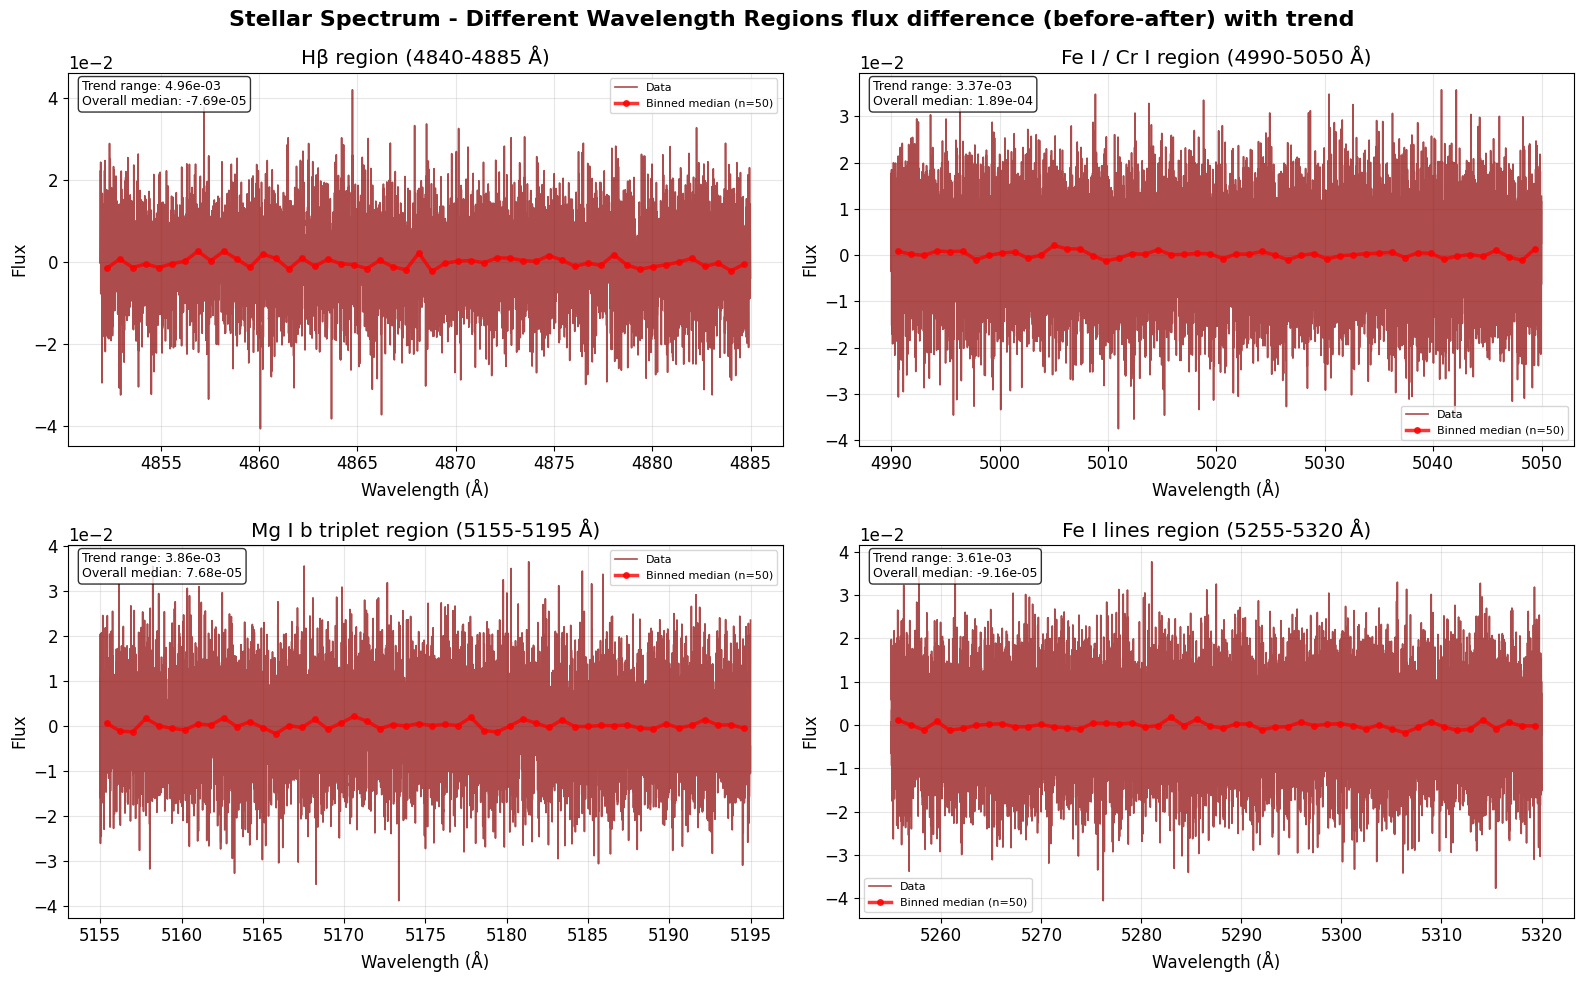

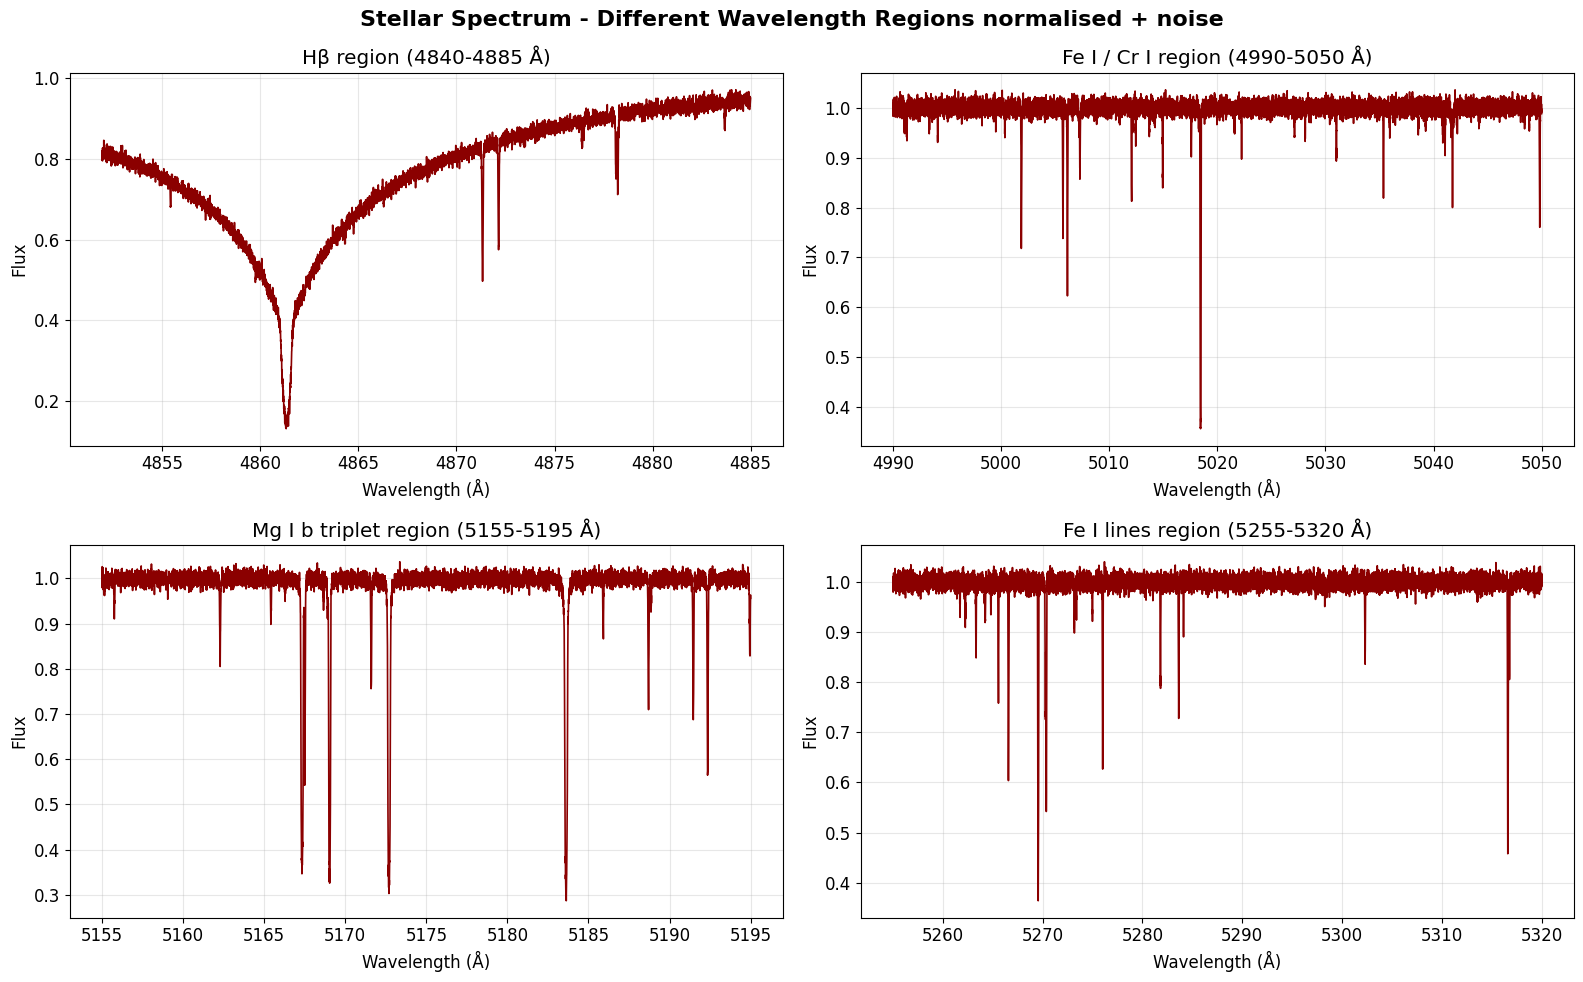

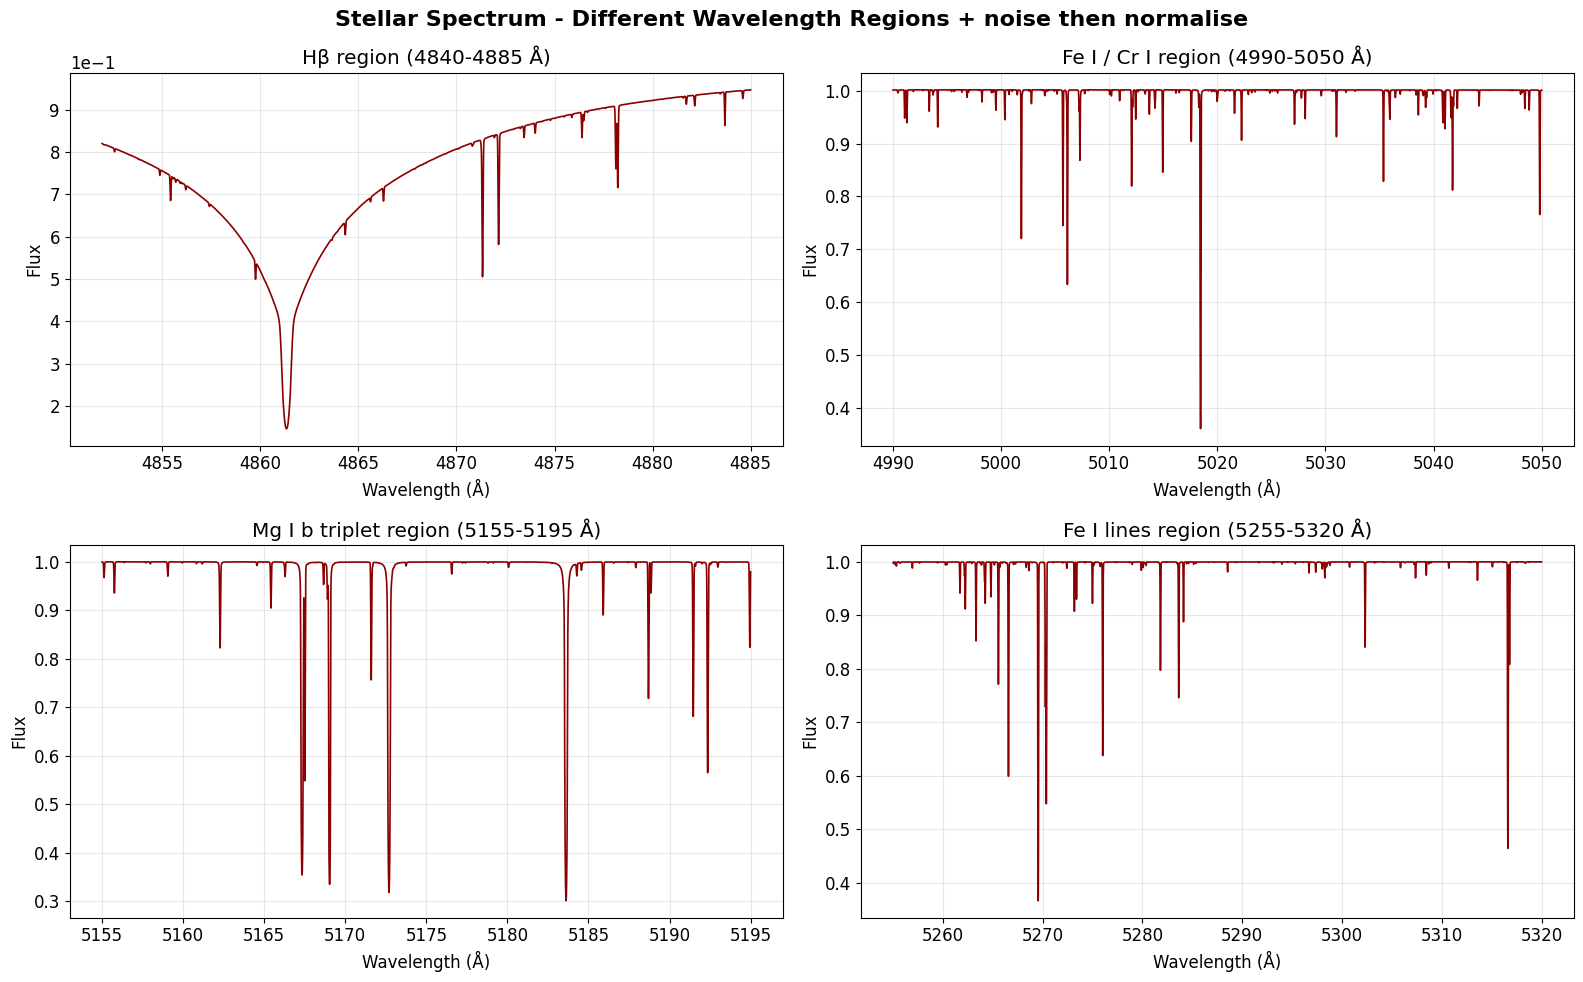

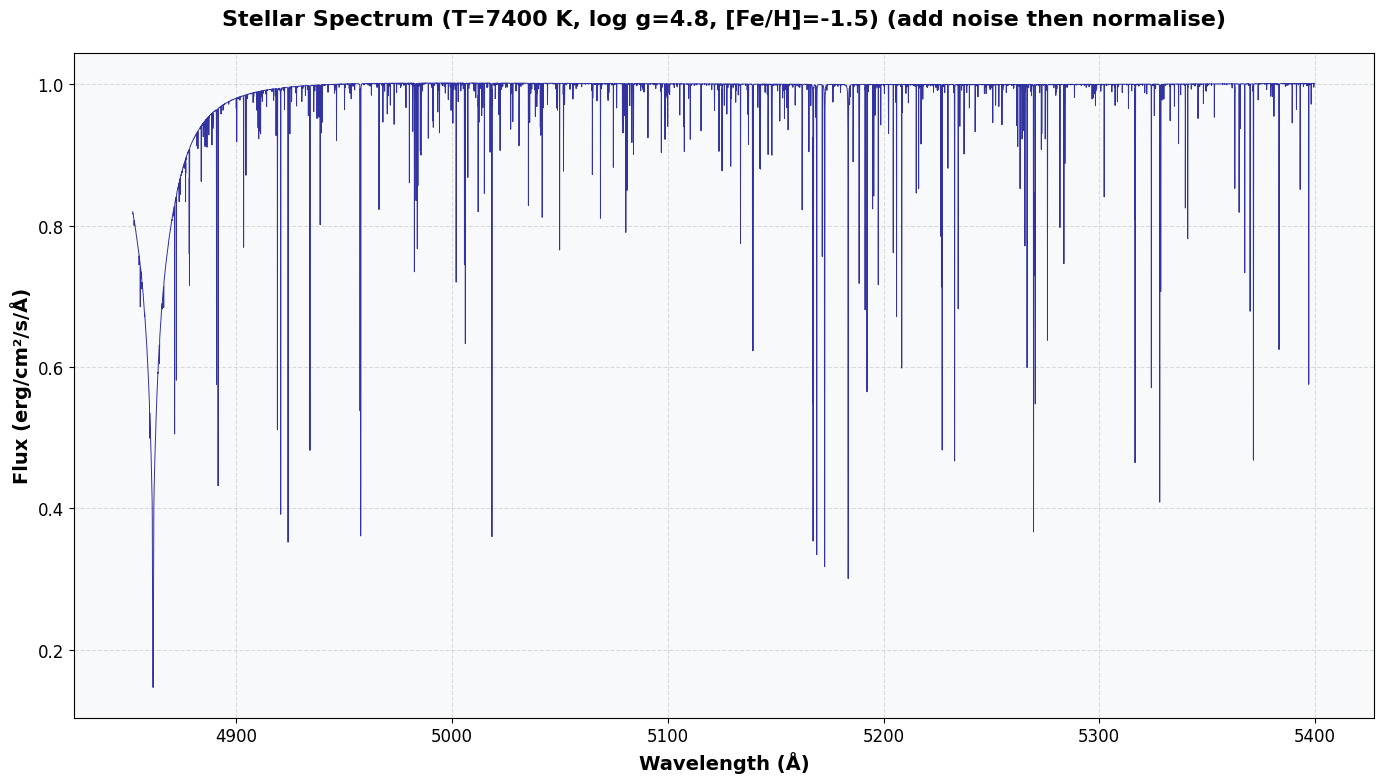


Analysis for spectrum 9696 with noise level 0.01:
Success: True
SNR: 99.8
Noise std: 0.010019
Correlation with -noise: 1.000
Elapsed time: 2.45s


In [28]:
# Use the enhanced version with trend analysis
plot_detailed_analysis_with_trend(19393 // 2, 0.01, "legendre_polyfit_huber", n_bins=50)

### Estimate normalisation error

In [29]:
def estimate_normalization_errors(spectrum_index, noise_level, method_name, n_bins=50, plot_errors=True):
    """
    Estimate various normalization error metrics from flux difference analysis.
    
    Args:
        spectrum_index (int): Index of the spectrum to analyze
        noise_level (float): Noise level to analyze
        method_name (str): Method name to determine file names
        n_bins (int): Number of bins for trend calculation
        plot_errors (bool): Whether to create error visualization plots
        
    Returns:
        dict: Dictionary containing various error estimates
    """
    try:
        # Load data (similar to your existing function)
        csv_file = f"{method_name}_results.csv"
        arrays_file = f"{method_name}_arrays.npz"
        
        df = pd.read_csv(csv_file)
        df_indexed = df.set_index(['spectrum_index', 'noise_level']).sort_index()
        row = df_indexed.loc[(spectrum_index, noise_level)]
        result_key = row['result_key']
        
        arrays = np.load(arrays_file, allow_pickle=True)
        array_data = arrays[result_key].item()
        
        wavelength = array_data.get('wavelength')
        method_A = array_data.get('method_A')  # normalize then add noise
        method_B = array_data.get('method_B')  # add noise then normalize
        flux_diff = array_data.get('flux_diff')  # method_B - method_A
        test_noise = array_data.get('test_noise')
        
        # Calculate various error metrics
        error_metrics = {}
        
        # 1. Global RMS error (overall normalization precision)
        rms_error = np.sqrt(np.mean(flux_diff**2))
        error_metrics['rms_error'] = rms_error
        
        # 2. Wavelength-dependent systematic error (binned trend analysis)
        wavelength_ranges = [
            (4840, 4885, "Hβ region"),
            (4990, 5050, "Fe I/Cr I region"), 
            (5155, 5195, "Mg I b region"),
            (5255, 5320, "Fe I lines region")
        ]
        
        regional_errors = {}
        for wmin, wmax, region_name in wavelength_ranges:
            mask = (wavelength >= wmin) & (wavelength <= wmax)
            if np.any(mask):
                region_diff = flux_diff[mask]
                regional_errors[region_name] = {
                    'rms': np.sqrt(np.mean(region_diff**2)),
                    'bias': np.mean(region_diff),  # systematic offset
                    'std': np.std(region_diff),   # random error
                    'median_abs_dev': np.median(np.abs(region_diff - np.median(region_diff)))
                }
        
        error_metrics['regional_errors'] = regional_errors
        
        # 3. Trend-based systematic error (using binned analysis)
        bin_edges = np.linspace(wavelength.min(), wavelength.max(), n_bins + 1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bin_medians = []
        bin_stds = []
        
        for i in range(len(bin_edges) - 1):
            bin_mask = (wavelength >= bin_edges[i]) & (wavelength < bin_edges[i+1])
            if i == len(bin_edges) - 2:
                bin_mask = (wavelength >= bin_edges[i]) & (wavelength <= bin_edges[i+1])
            
            if np.any(bin_mask):
                bin_data = flux_diff[bin_mask]
                bin_medians.append(np.median(bin_data))
                bin_stds.append(np.std(bin_data))
            else:
                bin_medians.append(np.nan)
                bin_stds.append(np.nan)
        
        bin_medians = np.array(bin_medians)
        bin_stds = np.array(bin_stds)
        
        # Remove NaN values
        valid_bins = ~np.isnan(bin_medians)
        if np.any(valid_bins):
            systematic_trend_error = np.std(bin_medians[valid_bins])  # variation in systematic error
            max_systematic_bias = np.max(np.abs(bin_medians[valid_bins]))
            random_error_variation = np.std(bin_stds[valid_bins])  # how much random error varies
        else:
            systematic_trend_error = np.nan
            max_systematic_bias = np.nan
            random_error_variation = np.nan
        
        error_metrics['systematic_trend_error'] = systematic_trend_error
        error_metrics['max_systematic_bias'] = max_systematic_bias
        error_metrics['random_error_variation'] = random_error_variation
        
        # 4. Signal-to-Noise based error scaling
        # Compare normalization error to input noise level
        input_noise_std = np.std(test_noise) if test_noise is not None else noise_level
        normalization_amplification = rms_error / input_noise_std if input_noise_std > 0 else np.nan
        error_metrics['normalization_amplification'] = normalization_amplification
        
        # 5. Correlation-based error (how well does method recover clean spectrum)
        correlation_with_neg_noise = row['correlation_with_neg_noise']
        robustness_score = correlation_with_neg_noise if not np.isnan(correlation_with_neg_noise) else 0
        error_metrics['robustness_score'] = robustness_score
        error_metrics['robustness_error'] = 1 - abs(robustness_score)  # 0 = perfect, 1 = worst
        
        # 6. Fractional error relative to spectrum level
        typical_spectrum_level = np.median(method_A)  # should be ~1 for normalized spectra
        fractional_rms_error = rms_error / typical_spectrum_level
        error_metrics['fractional_rms_error'] = fractional_rms_error
        
        # Create visualization if requested
        if plot_errors:
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            fig.suptitle(f'Normalization Error Analysis\nSpectrum {spectrum_index}, Noise {noise_level}', fontsize=14)
            
            # Plot 1: Error vs wavelength
            ax1 = axes[0, 0]
            ax1.scatter(wavelength, flux_diff, alpha=0.6, s=0.5, color='blue')
            ax1.axhline(0, color='red', linestyle='--', alpha=0.7)
            if np.any(valid_bins):
                ax1.plot(bin_centers[valid_bins], bin_medians[valid_bins], 'ro-', linewidth=2, markersize=4, label='Binned median')
                ax1.fill_between(bin_centers[valid_bins], 
                                bin_medians[valid_bins] - bin_stds[valid_bins],
                                bin_medians[valid_bins] + bin_stds[valid_bins],
                                alpha=0.3, color='red', label='±1σ envelope')
            ax1.set_xlabel('Wavelength (Å)')
            ax1.set_ylabel('Flux Difference')
            ax1.set_title('Wavelength-dependent Error')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Plot 2: Error distribution histogram
            ax2 = axes[0, 1]
            ax2.hist(flux_diff, bins=50, alpha=0.7, color='green', edgecolor='black')
            ax2.axvline(0, color='red', linestyle='--', label='Zero error')
            ax2.axvline(np.mean(flux_diff), color='orange', linestyle='-', label=f'Mean: {np.mean(flux_diff):.2e}')
            ax2.axvline(np.median(flux_diff), color='purple', linestyle='-', label=f'Median: {np.median(flux_diff):.2e}')
            ax2.set_xlabel('Flux Difference')
            ax2.set_ylabel('Count')
            ax2.set_title('Error Distribution')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            # Plot 3: Regional error comparison
            ax3 = axes[1, 0]
            region_names = list(regional_errors.keys())
            rms_values = [regional_errors[region]['rms'] for region in region_names]
            bias_values = [abs(regional_errors[region]['bias']) for region in region_names]
            
            x = np.arange(len(region_names))
            width = 0.35
            ax3.bar(x - width/2, rms_values, width, label='RMS Error', alpha=0.7)
            ax3.bar(x + width/2, bias_values, width, label='|Systematic Bias|', alpha=0.7)
            ax3.set_xlabel('Spectral Region')
            ax3.set_ylabel('Error Magnitude')
            ax3.set_title('Regional Error Comparison')
            ax3.set_xticks(x)
            ax3.set_xticklabels([name.replace(' region', '') for name in region_names], rotation=45)
            ax3.legend()
            ax3.grid(True, alpha=0.3)
            
            # Plot 4: Error scaling analysis
            ax4 = axes[1, 1]
            metrics_labels = ['RMS Error', 'Max |Bias|', 'Systematic Trend', 'Input Noise']
            metrics_values = [rms_error, max_systematic_bias, systematic_trend_error, input_noise_std]
            colors = ['blue', 'red', 'green', 'gray']
            
            bars = ax4.bar(metrics_labels, metrics_values, color=colors, alpha=0.7)
            ax4.set_ylabel('Error Magnitude')
            ax4.set_title('Error Component Comparison')
            ax4.tick_params(axis='x', rotation=45)
            ax4.grid(True, alpha=0.3)
            
            # Add value labels on bars
            for bar, value in zip(bars, metrics_values):
                if not np.isnan(value):
                    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(metrics_values)*0.01,
                           f'{value:.2e}', ha='center', va='bottom', fontsize=9)
            
            plt.tight_layout()
            plt.show()
        
        # Print summary
        print("=" * 60)
        print(f"NORMALIZATION ERROR ANALYSIS")
        print(f"Spectrum {spectrum_index}, Noise Level {noise_level}")
        print("=" * 60)
        print(f"Global RMS Error: {rms_error:.2e}")
        print(f"Fractional RMS Error: {fractional_rms_error:.1%}")
        print(f"Normalization Amplification Factor: {normalization_amplification:.2f}x")
        print(f"Robustness Score: {robustness_score:.3f} (1.0 = perfect)")
        print(f"Max Systematic Bias: {max_systematic_bias:.2e}")
        print(f"Systematic Trend Error: {systematic_trend_error:.2e}")
        print()
        print("Regional Errors:")
        for region, errors in regional_errors.items():
            print(f"  {region}:")
            print(f"    RMS: {errors['rms']:.2e}, Bias: {errors['bias']:.2e}")
            print(f"    Random: {errors['std']:.2e}, MAD: {errors['median_abs_dev']:.2e}")
        
        # Clean up
        arrays.close()
        
        return error_metrics
        
    except Exception as e:
        print(f"Error in normalization error analysis: {e}")
        import traceback
        traceback.print_exc()
        return None

# Convenience function to compare errors across noise levels
def compare_normalization_errors(spectrum_index, method_name, noise_levels=None):
    """
    Compare normalization errors across different noise levels for a given spectrum.
    
    Args:
        spectrum_index (int): Index of the spectrum to analyze
        method_name (str): Method name to determine file names
        noise_levels (list): List of noise levels to compare (if None, uses all available)
    """
    csv_file = f"{method_name}_results.csv"
    df = pd.read_csv(csv_file)
    
    # Get available noise levels for this spectrum
    spectrum_data = df[df['spectrum_index'] == spectrum_index]
    if noise_levels is None:
        noise_levels = sorted(spectrum_data['noise_level'].unique())
    
    # Calculate errors for each noise level
    results = []
    for noise_level in noise_levels:
        if noise_level in spectrum_data['noise_level'].values:
            error_metrics = estimate_normalization_errors(spectrum_index, noise_level, method_name, plot_errors=False)
            if error_metrics:
                error_metrics['noise_level'] = noise_level
                results.append(error_metrics)
    
    if not results:
        print("No valid results found for comparison")
        return
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Normalization Error vs Noise Level\nSpectrum {spectrum_index}, Method: {method_name}', fontsize=14)
    
    noise_vals = [r['noise_level'] for r in results]
    
    # Plot 1: RMS error vs noise level
    rms_errors = [r['rms_error'] for r in results]
    axes[0,0].loglog(noise_vals, rms_errors, 'bo-', linewidth=2, markersize=6)
    axes[0,0].loglog(noise_vals, noise_vals, 'r--', alpha=0.7, label='y=x (ideal scaling)')
    axes[0,0].set_xlabel('Input Noise Level')
    axes[0,0].set_ylabel('RMS Normalization Error')
    axes[0,0].set_title('Error Scaling with Noise')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Amplification factor vs noise level
    amplification = [r['normalization_amplification'] for r in results]
    axes[0,1].semilogx(noise_vals, amplification, 'go-', linewidth=2, markersize=6)
    axes[0,1].axhline(1.0, color='red', linestyle='--', alpha=0.7, label='No amplification')
    axes[0,1].set_xlabel('Input Noise Level')
    axes[0,1].set_ylabel('Error Amplification Factor')
    axes[0,1].set_title('Noise Amplification')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Robustness score vs noise level
    robustness = [r['robustness_score'] for r in results]
    axes[1,0].semilogx(noise_vals, robustness, 'mo-', linewidth=2, markersize=6)
    axes[1,0].axhline(1.0, color='green', linestyle='--', alpha=0.7, label='Perfect robustness')
    axes[1,0].axhline(0.8, color='orange', linestyle='--', alpha=0.7, label='Good threshold')
    axes[1,0].set_xlabel('Input Noise Level')
    axes[1,0].set_ylabel('Robustness Score')
    axes[1,0].set_title('Method Robustness')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Systematic vs random error components
    systematic_errors = [r['max_systematic_bias'] for r in results]
    random_errors = [r['rms_error'] for r in results]
    axes[1,1].loglog(noise_vals, systematic_errors, 'ro-', linewidth=2, markersize=6, label='Systematic')
    axes[1,1].loglog(noise_vals, random_errors, 'bo-', linewidth=2, markersize=6, label='Total RMS')
    axes[1,1].set_xlabel('Input Noise Level')
    axes[1,1].set_ylabel('Error Magnitude')
    axes[1,1].set_title('Systematic vs Random Error')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison table
    print("\nNormalization Error Summary Table:")
    print("-" * 80)
    print(f"{'Noise Level':<12} {'RMS Error':<12} {'Amplif.':<8} {'Robust.':<8} {'Frac. Error':<12}")
    print("-" * 80)
    for r in results:
        print(f"{r['noise_level']:<12.3f} {r['rms_error']:<12.2e} {r['normalization_amplification']:<8.2f} "
              f"{r['robustness_score']:<8.3f} {r['fractional_rms_error']:<12.1%}")
    
    return results

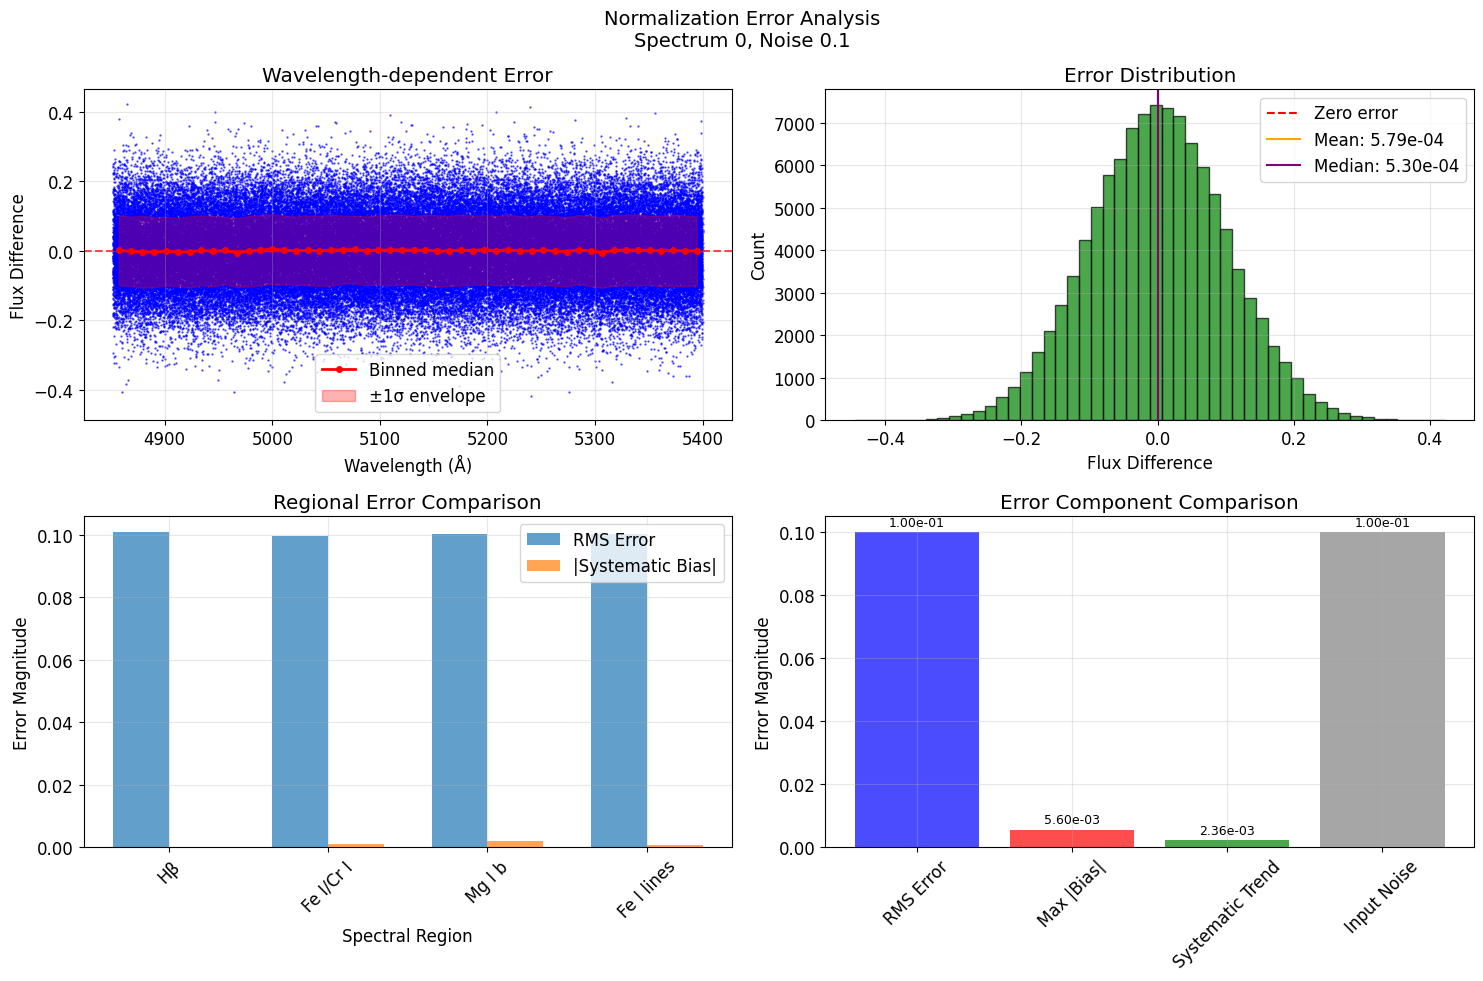

NORMALIZATION ERROR ANALYSIS
Spectrum 0, Noise Level 0.1
Global RMS Error: 1.00e-01
Fractional RMS Error: 10.3%
Normalization Amplification Factor: 1.00x
Robustness Score: 1.000 (1.0 = perfect)
Max Systematic Bias: 5.60e-03
Systematic Trend Error: 2.36e-03

Regional Errors:
  Hβ region:
    RMS: 1.01e-01, Bias: 1.53e-04
    Random: 1.01e-01, MAD: 6.82e-02
  Fe I/Cr I region:
    RMS: 9.97e-02, Bias: 9.38e-04
    Random: 9.97e-02, MAD: 6.69e-02
  Mg I b region:
    RMS: 1.00e-01, Bias: 1.99e-03
    Random: 1.00e-01, MAD: 6.72e-02
  Fe I lines region:
    RMS: 1.00e-01, Bias: -7.04e-04
    Random: 1.00e-01, MAD: 6.77e-02


In [31]:
# Analyze errors for a single spectrum/noise combination
error_metrics = estimate_normalization_errors(0, 0.1, "legendre_polyfit_huber", plot_errors=True)

NORMALIZATION ERROR ANALYSIS
Spectrum 0, Noise Level 0.005
Global RMS Error: 5.01e-03
Fractional RMS Error: 0.5%
Normalization Amplification Factor: 1.00x
Robustness Score: 1.000 (1.0 = perfect)
Max Systematic Bias: 2.79e-04
Systematic Trend Error: 1.18e-04

Regional Errors:
  Hβ region:
    RMS: 5.05e-03, Bias: 7.47e-06
    Random: 5.05e-03, MAD: 3.41e-03
  Fe I/Cr I region:
    RMS: 4.98e-03, Bias: 4.72e-05
    Random: 4.98e-03, MAD: 3.35e-03
  Mg I b region:
    RMS: 5.02e-03, Bias: 1.00e-04
    Random: 5.02e-03, MAD: 3.36e-03
  Fe I lines region:
    RMS: 5.01e-03, Bias: -3.44e-05
    Random: 5.01e-03, MAD: 3.38e-03
NORMALIZATION ERROR ANALYSIS
Spectrum 0, Noise Level 0.01
Global RMS Error: 1.00e-02
Fractional RMS Error: 1.0%
Normalization Amplification Factor: 1.00x
Robustness Score: 1.000 (1.0 = perfect)
Max Systematic Bias: 5.59e-04
Systematic Trend Error: 2.36e-04

Regional Errors:
  Hβ region:
    RMS: 1.01e-02, Bias: 1.51e-05
    Random: 1.01e-02, MAD: 6.82e-03
  Fe I/Cr I re

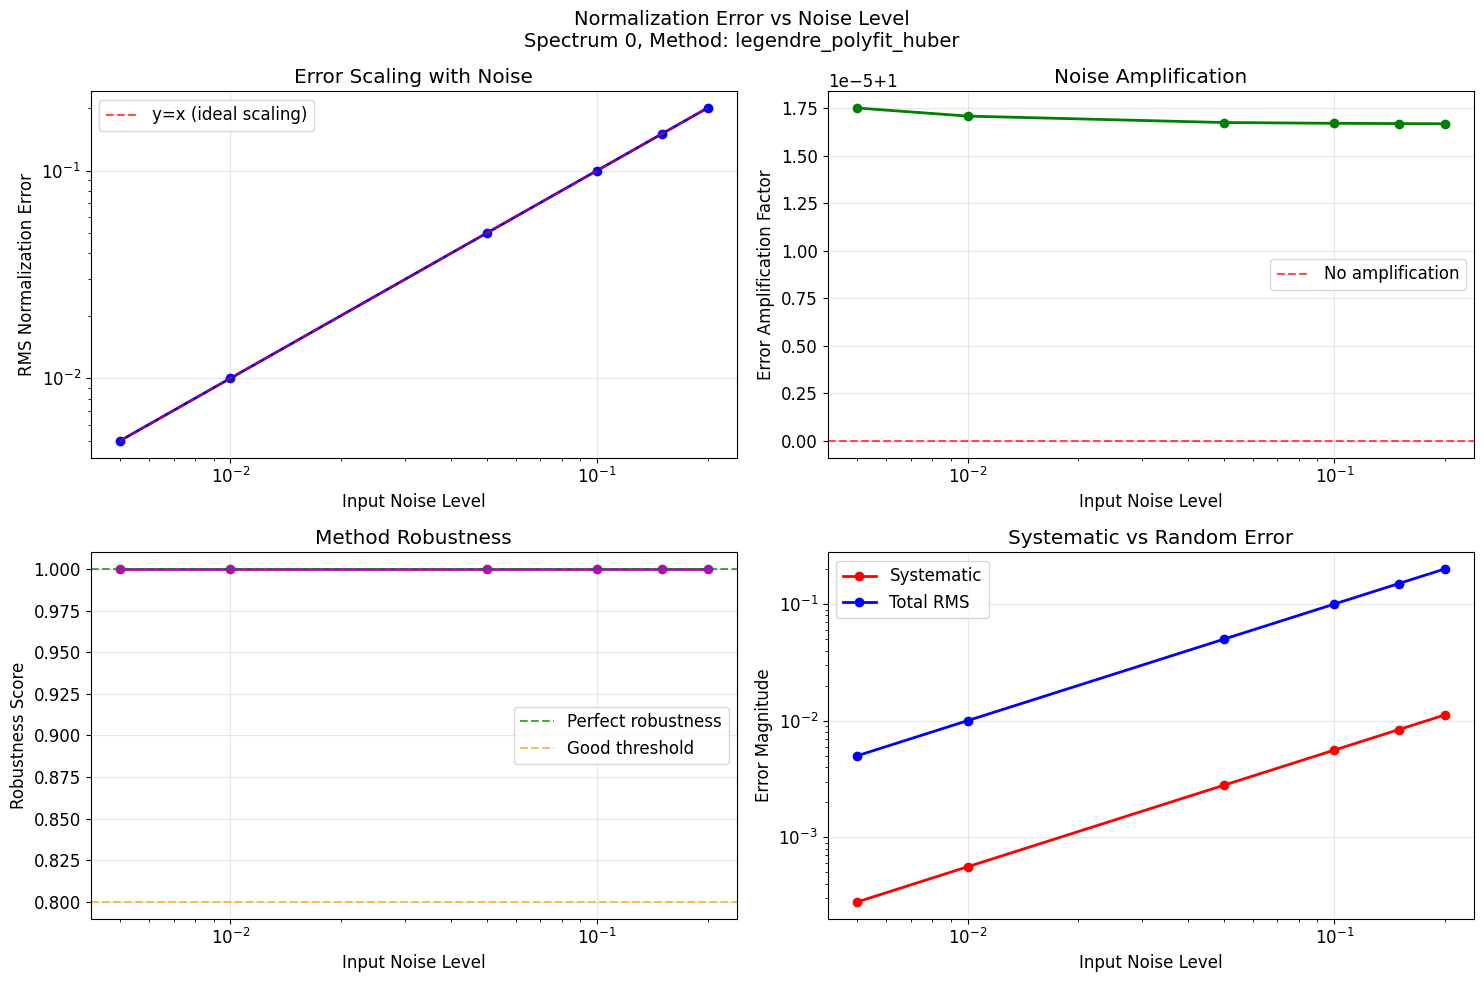


Normalization Error Summary Table:
--------------------------------------------------------------------------------
Noise Level  RMS Error    Amplif.  Robust.  Frac. Error 
--------------------------------------------------------------------------------
0.005        5.01e-03     1.00     1.000    0.5%        
0.010        1.00e-02     1.00     1.000    1.0%        
0.050        5.01e-02     1.00     1.000    5.1%        
0.100        1.00e-01     1.00     1.000    10.3%       
0.150        1.50e-01     1.00     1.000    15.5%       
0.200        2.00e-01     1.00     1.000    20.8%       


In [32]:
# Compare errors across all noise levels for a spectrum
results = compare_normalization_errors(0, "legendre_polyfit_huber")

NORMALIZATION ERROR ANALYSIS
Spectrum 9696, Noise Level 0.01
Global RMS Error: 7.24e-06
Fractional RMS Error: 0.0%
Normalization Amplification Factor: 0.00x
Robustness Score: 1.000 (1.0 = perfect)
Max Systematic Bias: 7.54e-09
Systematic Trend Error: 3.14e-09

Regional Errors:
  Hβ region:
    RMS: 5.13e-06, Bias: -7.79e-08
    Random: 5.13e-06, MAD: 1.45e-08
  Fe I/Cr I region:
    RMS: 7.13e-06, Bias: -1.25e-07
    Random: 7.12e-06, MAD: 1.52e-08
  Mg I b region:
    RMS: 7.18e-06, Bias: -9.64e-08
    Random: 7.18e-06, MAD: 1.49e-08
  Fe I lines region:
    RMS: 3.02e-06, Bias: -5.41e-08
    Random: 3.02e-06, MAD: 1.36e-08
NORMALIZATION ERROR ANALYSIS
Spectrum 9696, Noise Level 0.05
Global RMS Error: 7.24e-06
Fractional RMS Error: 0.0%
Normalization Amplification Factor: 0.00x
Robustness Score: 1.000 (1.0 = perfect)
Max Systematic Bias: 7.54e-09
Systematic Trend Error: 3.14e-09

Regional Errors:
  Hβ region:
    RMS: 5.13e-06, Bias: -7.79e-08
    Random: 5.13e-06, MAD: 1.45e-08
  Fe 

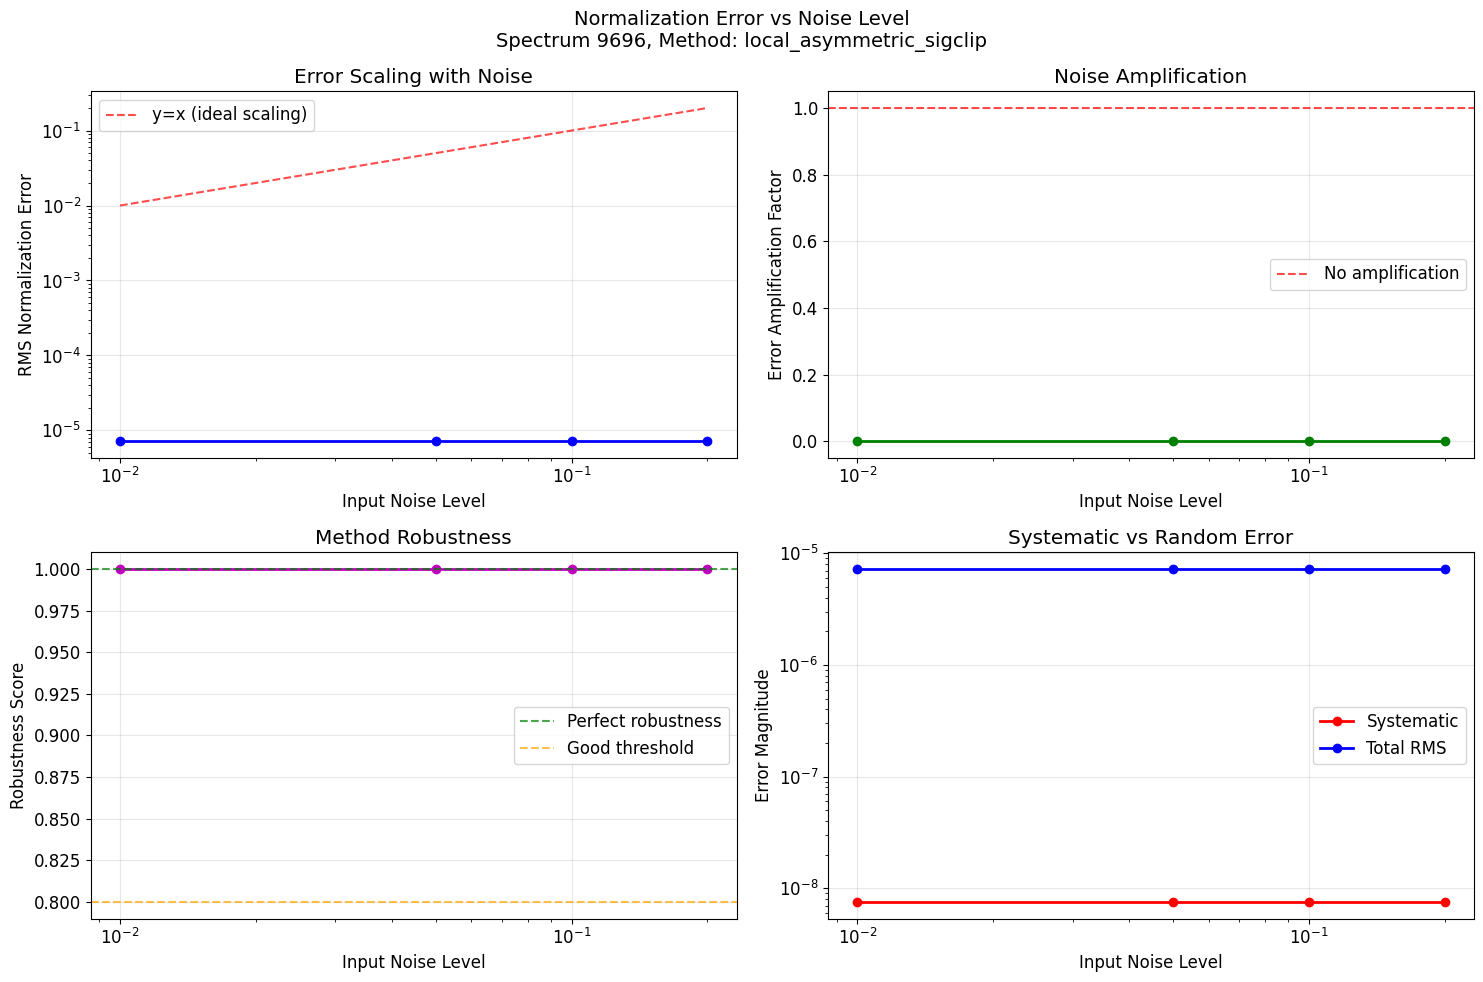


Normalization Error Summary Table:
--------------------------------------------------------------------------------
Noise Level  RMS Error    Amplif.  Robust.  Frac. Error 
--------------------------------------------------------------------------------
0.010        7.24e-06     0.00     1.000    0.0%        
0.050        7.24e-06     0.00     1.000    0.0%        
0.100        7.24e-06     0.00     1.000    0.0%        
0.200        7.24e-06     0.00     1.000    0.0%        


In [33]:
# Compare specific noise levels
results = compare_normalization_errors(19393//2, "local_asymmetric_sigclip", 
                                     noise_levels=[0.01, 0.05, 0.1, 0.2])

### Compare re-sampled (before cont norm) with original spectrum

In [ ]:
data_path = '/home/minjihk/projects/rrg-kyi/astro/data/weave/nlte-grids/train_nlte'
filename = info['filename']
file_path = os.path.join(data_path, filename)

waves_raw = []
flux_raw = []
data_started = False

with open(file_path, 'r') as fh:
    for raw in fh:
        line = raw.strip()
        if line == "# wave, flux":
            # marker that data lines follow
            data_started = True
            continue
        if data_started and not line.startswith('#'):
            # data lines: first column is wavelength
            parts = line.split()
            waves_raw.append(float(parts[0]))
            flux_raw.append(float(parts[1]))

plt.plot(waves_raw, flux_raw, linewidth=0.8, color='black')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.title('Stellar Spectrum: Wavelength vs Flux original file')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(waves_raw, flux_raw, linewidth=0.8, color='black', label = 'original')
plt.plot(wavelength, flux, linewidth=0.8, color='blue', label = 'resampled')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.title('Stellar Spectrum: Wavelength vs Flux')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(waves_raw, flux_raw, linewidth=0.8, color='black', label = 'original', alpha=0.5)
plt.plot(wavelength, flux, linewidth=0.8, color='blue', label = 'resampled', alpha=0.5)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.title('Stellar Spectrum: Wavelength vs Flux')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim((5000,5001))
plt.ylim((4.9e14,5.1e14))
plt.show()

## Plot NIST lines

In [ ]:
def plot_spectrum_NIST(wavelength, flux, headers):
    # Create a more detailed, publication-ready plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot the spectrum
    ax.plot(wavelength, flux, linewidth=0.7, color='darkblue', alpha=0.8)

    # Load your NIST CSV
    line_table = pd.read_csv("../data/NIST_lines.csv", sep=",")  # adjust sep if needed

    def safe_float(x):
        try:
            # Remove unwanted characters
            x_clean = x.replace('=', '').replace('"', '')
            return float(x_clean)
        except (ValueError, AttributeError):
            # Return NaN if conversion fails
            return np.nan

    # Apply to the column
    line_table['obs_wl_air(A)'] = np.array([safe_float(x) for x in line_table['obs_wl_air(A)']], dtype=float)

    # Use only lines within your spectrum's wavelength range
    lines_in_range = line_table[(line_table['obs_wl_air(A)'] >= wavelength[0]) &
                                (line_table['obs_wl_air(A)'] <= wavelength[-1])]
    
    # Plot lines and add to legend
    for idx, row in lines_in_range.iterrows():
        lam = row['obs_wl_air(A)']
        species = row['element']
        plt.axvline(lam, linestyle='--', alpha=0.6, label=species)

    # Customize the plot
    ax.set_xlabel('Wavelength (Å)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Flux (erg/cm²/s/Å)', fontsize=14, fontweight='bold')
    
    # Create title with stellar parameters
    title = f"Stellar Spectrum (T={int(headers['teff'])} K, log g={headers['log_g']:.1f}, [Fe/H]={headers['metallicity']:.1f})"
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    
    # Improve grid and styling
    ax.grid(True, alpha=0.4, linestyle='--')
    ax.set_facecolor('#f8f9fa')
    
    # Format the axes
    ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Add some spacing
    plt.tight_layout()
    plt.show()

In [ ]:
plot_spectrum_NIST(wavelength, flux, headers)

## 7. Save Plot and Data

Save the plots and processed data for future use.

# Save the main spectrum plot
plt.figure(figsize=(14, 8))
plt.plot(wavelength, flux, linewidth=0.7, color='darkblue', alpha=0.8)
plt.xlabel('Wavelength (Å)', fontsize=14, fontweight='bold')
plt.ylabel('Flux (erg/cm²/s/Å)', fontsize=14, fontweight='bold')
title = f"Stellar Spectrum (T={headers.get('teff', 'N/A')}K, log g={headers.get('log_g', 'N/A')}, [Fe/H]={headers.get('metallicity', 'N/A')})"
plt.title(title, fontsize=16, fontweight='bold', pad=20)
plt.grid(True, alpha=0.4, linestyle='--')
plt.gca().set_facecolor('#f8f9fa')
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
plt.tight_layout()

# Save the plot
plt.savefig('stellar_spectrum_plot.png', dpi=300, bbox_inches='tight')
plt.savefig('stellar_spectrum_plot.pdf', bbox_inches='tight')
print("Plot saved as 'stellar_spectrum_plot.png' and 'stellar_spectrum_plot.pdf'")
plt.show()

# Save processed data for this spectrum
import pandas as pd
df = pd.DataFrame({'wavelength': wavelength, 'flux': flux})
df.to_csv('processed_spectrum_data.csv', index=False)
print(f"Data saved to 'processed_spectrum_data.csv' with {len(df)} data points")